# Import libraries and set configs

In [1]:
import sys
sys.path.append('..')

import os
import json
import joblib
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

from eli5.sklearn import PermutationImportance

import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, confusion_matrix, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

from colorama import Style, Fore

# Set environment variable
environ["ENV"] = "optimize"

from config.config import ConfigFactory
from indicators import indicators

from api.tvdatafeed.main import TvDatafeed, Interval
from constants.constants import tv_username, tv_password

from datetime import datetime


class CFG:
    load = True
    historical = False
    create_dataset = True
    update_dataset = True
    cls_target_ratio_tp = 1.03
    cls_target_ratio_sl = 1.03
    ttype = 'both'
    patterns_to_filter = ['STOCH_RSI_Volume24']
    select_features = False
    optimize = False
    n_repeats = 1
    n_folds = 8
    last_date = datetime.strptime("2024-04-19:10:00:00", "%Y-%m-%d:%H:%M:%S")
    agg_periods = [24, 72]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

tqdm.pandas()

warnings.simplefilter(action='ignore', category=(FutureWarning, pd.errors.PerformanceWarning))

# Load data

### Load STOCH_RSI buy data

In [2]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'buy'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 31060

Timeframe is 1h/4h, trade type is buy
Number of combinations is 1


  0%|          | 0/1 [00:00<?, ?it/s]error while signin
you are using nologin method, data you access may be limited
/home/alex/Trading/sigbot/sigbot/ml/../log/log.py:72: RuntimeWarning: coroutine 'Application.shutdown' was never awaited
  format_exception(function)
/home/alex/Trading/sigbot/sigbot/ml/../log/log.py:72: RuntimeWarning: coroutine 'Application.initialize' was never awaited
  format_exception(function)



Load the datasets...
ByBitPerpetual
10000000AIDOGEUSDT
10000COQUSDT
10000LADYSUSDT
10000NFTUSDT
10000SATSUSDT
10000STARLUSDT
10000WENUSDT
1000BONKUSDT
1000BTTUSDT
1000FLOKIUSDT
1000IQ50USDT
1000LUNCUSDT
1000PEPEUSDT
1000RATSUSDT
1000TURBOUSDT
1000XECUSDT
1CATUSDT
1INCHUSDT
AAVEUSDT
ACEUSDT
ACHUSDT
ADAUSDT
AERGOUSDT
AEVOUSDT
AGIUSDT
AGIXUSDT
AGLDUSDT
AIUSDT
AKROUSDT
ALGOUSDT
ALICEUSDT
ALPACAUSDT
ALPHAUSDT
ALTUSDT
AMBUSDT
ANKRUSDT
ANTUSDT
APEUSDT
API3USDT
APTUSDT
ARBUSDT
ARKMUSDT
ARKUSDT
ARPAUSDT
ARUSDT
ASTRUSDT
ATAUSDT
ATOMUSDT
AUCTIONUSDT
AUDIOUSDT
AVAXUSDT
AXLUSDT
AXSUSDT
BADGERUSDT
BAKEUSDT
BALUSDT
BANDUSDT
BATUSDT
BCHUSDT
BEAMUSDT
BELUSDT
BICOUSDT
BIGTIMEUSDT
BLURUSDT
BLZUSDT
BNBUSDT
BNTUSDT
BNXUSDT
BOBAUSDT
BOMEUSDT
BONDUSDT
BSVUSDT
BSWUSDT
BTCUSDT
C98USDT
CAKEUSDT
CEEKUSDT
CELOUSDT
CELRUSDT
CETUSUSDT
CFXUSDT
CHRUSDT
CHZUSDT
CKBUSDT
COMBOUSDT
COMPUSDT
COREUSDT
COTIUSDT
COVALUSDT
CROUSDT
CRVUSDT
CTCUSDT
CTKUSDT
CTSIUSDT
CVCUSDT
CVXUSDT
CYBERUSDT
DAOUSDT
DARUSDT
DASHUSDT
DATAUSDT
DE

100%|██████████| 1/1 [43:05<00:00, 2585.73s/it]


,pattern,RSI_timeperiod,RSI_low_bound,STOCH_fastk_period,STOCH_slowk_period,STOCH_slowd_period,STOCH_low_bound,e_ratio_1,e_ratio_2,e_ratio_3,e_ratio_4,e_ratio_5,e_ratio_6,e_ratio_7,e_ratio_8,e_ratio_9,e_ratio_10,e_ratio_11,e_ratio_12,e_ratio_13,e_ratio_14,e_ratio_15,e_ratio_16,e_ratio_17,e_ratio_18,e_ratio_19,e_ratio_20,e_ratio_21,e_ratio_22,e_ratio_23,e_ratio_24,pct_price_diff_1,pct_price_diff_2,pct_price_diff_3,pct_price_diff_4,pct_price_diff_5,pct_price_diff_6,pct_price_diff_7,pct_price_diff_8,pct_price_diff_9,pct_price_diff_10,pct_price_diff_11,pct_price_diff_12,pct_price_diff_13,pct_price_diff_14,pct_price_diff_15,pct_price_diff_16,pct_price_diff_17,pct_price_diff_18,pct_price_diff_19,pct_price_diff_20,pct_price_diff_21,pct_price_diff_22,pct_price_diff_23,pct_price_diff_24,forecasts_num
0,STOCH_RSI_Volume24,14,35,9,7,3,25,0.9327,0.9101,0.8963,0.9049,0.9094,0.9196,0.9432,0.9421,0.9444,0.9546,0.9554,0.9649,0.9706,0.9731,0.977,0.9815,0.9899,1.0031,1.0091,1.0136,1.0194,1.0197,1.0195,1.0189,-0.41,-0.86,-1.26,-1.67,-2.08,-2.49,-2.91,-3.33,-3.76,-4.21,-4.71,-5.3,-70.47,-2893.73,-3127.27,-4206.97,-7627.47,-12645.37,-13334.68,-14240.81,-15230.09,-16418.33,-26140.87,-27552.22,47794


### Load STOCH_RSI sell data

In [3]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'sell'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 23629

Timeframe is 1h/4h, trade type is sell
Number of combinations is 1


  0%|          | 0/1 [00:00<?, ?it/s]error while signin
you are using nologin method, data you access may be limited
/home/alex/Trading/sigbot/sigbot/ml/../log/log.py:72: RuntimeWarning: coroutine 'Application.shutdown' was never awaited
  format_exception(function)
/home/alex/Trading/sigbot/sigbot/ml/../log/log.py:72: RuntimeWarning: coroutine 'Application.initialize' was never awaited
  format_exception(function)
100%|██████████| 1/1 [05:11<00:00, 311.99s/it]


,pattern,RSI_timeperiod,RSI_low_bound,STOCH_fastk_period,STOCH_slowk_period,STOCH_slowd_period,STOCH_low_bound,e_ratio_1,e_ratio_2,e_ratio_3,e_ratio_4,e_ratio_5,e_ratio_6,e_ratio_7,e_ratio_8,e_ratio_9,e_ratio_10,e_ratio_11,e_ratio_12,e_ratio_13,e_ratio_14,e_ratio_15,e_ratio_16,e_ratio_17,e_ratio_18,e_ratio_19,e_ratio_20,e_ratio_21,e_ratio_22,e_ratio_23,e_ratio_24,pct_price_diff_1,pct_price_diff_2,pct_price_diff_3,pct_price_diff_4,pct_price_diff_5,pct_price_diff_6,pct_price_diff_7,pct_price_diff_8,pct_price_diff_9,pct_price_diff_10,pct_price_diff_11,pct_price_diff_12,pct_price_diff_13,pct_price_diff_14,pct_price_diff_15,pct_price_diff_16,pct_price_diff_17,pct_price_diff_18,pct_price_diff_19,pct_price_diff_20,pct_price_diff_21,pct_price_diff_22,pct_price_diff_23,pct_price_diff_24,forecasts_num
0,STOCH_RSI_Volume24,14,35,9,7,3,25,0.9524,0.8986,0.8717,0.8538,0.8288,0.8171,0.8048,0.7938,0.7874,0.7774,0.7666,0.7573,0.7575,0.7563,0.7553,0.7553,0.7511,0.7479,0.7411,0.7358,0.7328,0.7319,0.7293,0.7306,0.44,0.86,1.28,1.68,2.07,2.46,2.84,3.21,3.57,3.92,4.26,4.58,4.87,5.12,5.32,5.48,5.61,5.71,5.78,5.82,5.82,5.81,5.78,5.77,37162


# Test loaded data

### Remove dataframe files with the biggest number of missing data

In [4]:
counter = 0 

tickers_1h = glob('../optimizer/ticker_dataframes/*_1h.pkl')
for ticker in tqdm(tickers_1h[3:]):
    df = pd.read_pickle(ticker)
    nunique = df['time'].diff()[1:].nunique()
    if nunique > 1:
        count = df[df['time'].diff().astype('timedelta64[h]') != 1].shape[0]
        if count > 200:
            print(ticker, nunique, count)
            os.remove(ticker)
            os.remove(ticker[:-6] + '4h.pkl')
            
counter

  0%|          | 0/2992 [00:00<?, ?it/s]

0

### Plot time vs index for some of dataframe files

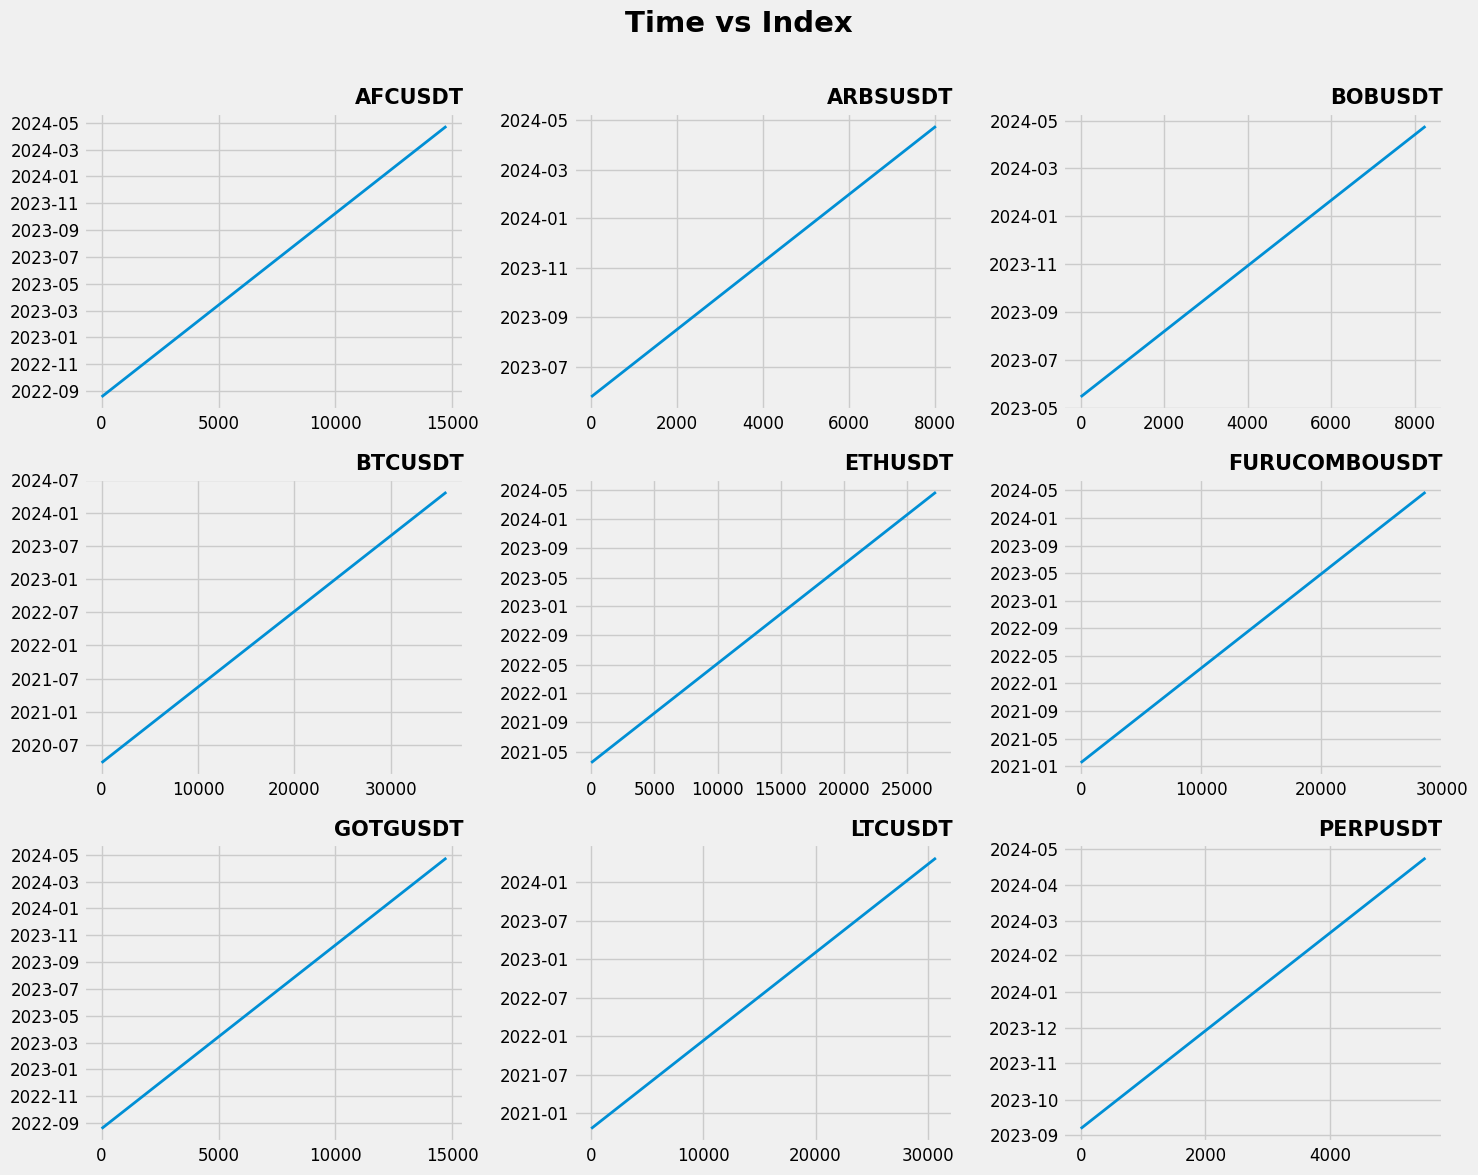

In [5]:
%matplotlib inline

n_cols = 3
n_rows = 3
figsize = (15, 4 * n_rows)

tickers = glob('../optimizer/ticker_dataframes/*_1h.pkl')
random_tickers = random.choices(tickers, k=n_cols*n_rows)
random_tickers[:3] = [t for t in tickers if '/BTCUSDT_1h' in t or '/ETHUSDT_1h' in t or '/LTCUSDT_1h' in t]

def plot_times(random_tickers, n_rows, n_cols):
    fig = plt.figure(figsize=figsize)
    
    for idx in range(n_cols*n_rows):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        df = pd.read_pickle(random_tickers[idx])
        sns.lineplot(data=df['time'])

        ax.set_ylabel('')
        plt.yticks(fontsize=12) 
        ax.set_xlabel('')
        plt.xticks(fontsize=12)
        # ax.spines['right'].set_visible(False)
        ax.set_title(f'{random_tickers[idx].split("/")[-1][:-7]}', loc='right', weight='bold', fontsize=15)
        ax.lines[0].set_linewidth(2)

    
    fig.suptitle(f'Time vs Index\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
plot_times(sorted(random_tickers),  n_rows=n_rows, n_cols=n_cols) 

### Check if all dataframe files has data for both timeframes 1h and 4h

In [6]:
import glob

x = glob.glob('../optimizer/ticker_dataframes/*.pkl')
y = [i[31:].split('_')[0] for i in x]
z = ('').join(x)

for i in y:
    if f'{i}_1h' not in z:
        print(i, '1h')
    if f'{i}_4h' not in z:
        print(i, '4h')

# Prepare and create train data

### Functions

In [59]:
# Get configs
configs = ConfigFactory.factory(environ).configs

higher_features = ['time', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist', 'macdsignal']
price_cols = ['open','high', 'low', 'close']
real_price_cols = ['real_high', 'real_low', 'real_close']
funding_cols = ['funding_rate']
rsi_stoch_cols = ['rsi', 'stoch_diff', 'stoch_slowd', 'stoch_slowk']
btcd_cols = ['time', 'btcd_open', 'btcd_high', 'btcd_low', 'btcd_close', 'btcd_volume']
btcdom_cols = ['time', 'btcdom_open', 'btcdom_high', 'btcdom_low', 'btcdom_close', 'btcdom_volume']

def get_file(ticker):
    ''' Find files buy ticker names '''
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h

def add_indicators(df, df_higher, ttype, configs):
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, '', '', 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, '', '', 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, '', '', 0)
    # add CCI
    cci = indicators.CCI(ttype, configs)
    df = cci.get_indicator(df, '', '', 0)
    # add SAR
    sar = indicators.SAR(ttype, configs)
    df = sar.get_indicator(df, '', '', 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, '', '', 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, '', '', 0)
    # merge higher timeframe indicators with working timeframe
    df_higher['time'] = df_higher['time'] + pd.to_timedelta(3, unit='h')
    df[higher_features] = pd.merge(df[['time']], df_higher[higher_features], how='left', on='time')
    df.drop(columns=['close_smooth'], inplace=True)
    df.drop(columns=[c for c in df.columns if c.endswith('_dir')], inplace=True)
    # merge with BTC.D dataframe
    df[btcd_cols] = pd.merge(df[['time']], btcd[btcd_cols], how='left', on='time')
    # merge with BTCDOM dataframe
    df[btcdom_cols] = pd.merge(df[['time']], btcdom[btcdom_cols], how='left', on='time')
    df.ffill(inplace=True)
    df[btcdom_cols] = df[btcdom_cols].fillna(df[btcdom_cols].mean().round(1))
    # price and MACD columns to pct difference
    df[real_price_cols] = df[['high', 'low', 'close']]
    cols_to_scale = ['open', 'high', 'low', 'close', 'macd', 'macdhist', 'macdsignal', 'atr']
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    # # add aggregate values
    # for col in ['close', 'btcd_close', 'btcdom_close']:
    #     for period in CFG.agg_periods:
    #         for agg_func in CFG.agg_funcs:
    #             df[f'{col}_{agg_func.__name__}_{period}'] = df[col].rolling(period, min_periods=1).agg({'func': agg_func})
    return df.reset_index(drop=True)


def create_train_df(df, ttype, configs, target_offset, first, last, step, train_df_prev=None):
    ''' Create train dataset from signal statistics and ticker candle data'''
    train_df = pd.DataFrame()
    tickers = df['ticker'].unique()
    
    for ticker in tqdm(tickers):
        
        # get signals with current ticker
        signal_df = df[df['ticker'] == ticker]
        times = signal_df['time']
        
        # load max time for that ticker from the previously created dataset
        if train_df_prev is not None:
            max_time = train_df_prev.loc[train_df_prev['ticker'] == ticker, 'time'].max()
        else:
            max_time = None
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f'TypeError, ticker - {ticker}')
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            if max_time and t <= max_time:
                continue
            
            pass_cycle = False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc('pattern')]
            row = tmp_df_1h.loc[tmp_df_1h['time'] == t, :].reset_index(drop=True)
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h['time'] == time_prev, [c for c in tmp_df_1h.columns if c not in real_price_cols]].reset_index(drop=True)
                    if i % 8 != 0:
                        row_tmp = row_tmp.drop(columns=funding_cols)
                    if i % 24 != 0:
                        row_tmp = row_tmp.drop(columns=btcd_cols)
                    row_tmp.columns = [c + f'_prev_{i}' for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row['ticker'] = ticker
                row['pattern'] = pattern
                
            if pass_cycle:
                continue

            row['target'] = 0
            row['ttype'] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith('MACD'):
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t + timedelta(hours=3), 'real_close']
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t, 'real_close']

            # move to the next ticker if can't find any data corresponding to time t
            if close_price.shape[0] == 0:
                continue
            
            close_price = close_price.values[0]
            
            for i in range(1, target_offset + 1):
                if pattern.startswith('MACD'):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                    
                target_buy = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_high']
                target_sell = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_low']
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                # set 
                higher_price = close_price * CFG.cls_target_ratio_tp
                lower_price = close_price * (2 - CFG.cls_target_ratio_tp)
                target_buy_tp = 1 if target_buy > higher_price else 0
                target_buy_sl = 1 if target_buy > higher_price else 0
                target_sell_tp = 1 if target_sell < lower_price else 0
                target_sell_sl = 1 if target_sell < lower_price else 0

                pattern = row['pattern'].values[0]
                ttype = row['ttype'].values[0]
                
                # set SL flag and exit cycle if price reaches stop-loss threshold before it reaches take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith('STOCH') and ttype == 'buy' and target_buy_sl == 1
                sl2 = pattern.startswith('STOCH') and ttype == 'sell' and target_sell_sl == 1

                # set TP flag and exit cycle if price reaches take-profit threshold and doesn't reach stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith('STOCH') and ttype == 'buy' and target_sell_tp == 1
                tp2 = pattern.startswith('STOCH') and ttype == 'sell' and target_buy_tp == 1
                    
                # if both TP and SL flag is on - don't consider that trade
                if (tp1 and sl1) or (tp2 and sl2):
                    pass_cycle = True
                    break
                elif sl1 or sl2:
                    break
                elif tp1 or tp2:
                    row['target'] = 1
                    break
                
                # if price doesn't reaches both TP and SL thresholds but price above / below enter price for buy / sell trade - set TP flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_close'].values[0]
                    l1 = pattern.startswith('STOCH') and ttype == 'buy' and last_price < close_price
                    l2 = pattern.startswith('STOCH') and ttype == 'sell' and last_price > close_price

                    if l1 or l2:
                        row['target'] = 1
            
            if pass_cycle:
                continue
            
            # add data to the dataset
            if train_df.shape[0] == 0:
                train_df = row
            else:
                train_df = pd.concat([train_df, row])
    
    train_df = train_df.drop(columns=real_price_cols)
    return train_df


### Prepare train data

In [61]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 272
# for how long time (in hours) we want to predict
target_offset = 96

if CFG.create_dataset:
    # Get BTC dominance
    tv = TvDatafeed(username=tv_username, password=tv_password)
    
    btcd = tv.get_hist('BTC.D','CRYPTOCAP', interval=Interval.in_daily, n_bars=7000, extended_session=True).reset_index()
    btcd = btcd.drop(columns='symbol')
    btcd.columns = btcd_cols
    btcd['time'] = btcd['time'] + pd.to_timedelta(23, unit='h')

    btcdom = tv.get_hist('BTCDOMUSDT.P','BINANCE', interval=Interval.in_4_hour, n_bars=7000, extended_session=True).reset_index()
    btcdom = btcdom.drop(columns='symbol')
    btcdom.columns = btcdom_cols
    btcdom['time'] = btcdom['time'] + pd.to_timedelta(3, unit='h')
    
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # good hours: 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    buy_hours_to_save = [0, 1, 2, 3, 16, 17, 21, 22, 23]
    df = df[df['time'].dt.hour.isin(buy_hours_to_save)]
    # if previously generated dataset exists - update it, don't create it from scratch
    train_df_prev = None
    if CFG.update_dataset:
        try:
            train_df_prev = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
        except FileNotFoundError:
            pass
    # dataset for model training
    train_buy = create_train_df(df, 'buy', configs, target_offset, first, last, step, train_df_prev)
    train_buy = train_buy.dropna()
    if CFG.update_dataset and train_df_prev is not None:
        train_buy = pd.concat([train_df_prev, train_buy]).reset_index(drop=True)
    train_buy.to_pickle(f'signal_stat/train_buy_{last}.pkl')

    display(train_buy.head())
    display(train_buy.shape)

    # Sell
    # good hours 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    sell_hours_to_save = [1, 4, 14, 16, 17, 18, 19, 21, 22, 23]
    df = df[df['time'].dt.hour.isin(sell_hours_to_save)]
    # if previously generated dataset exists - update it, don't create it from scratch
    train_df_prev = None
    if CFG.update_dataset:
        try:
            train_df_prev = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')
        except FileNotFoundError:
            pass
    # dataset for model training
    train_sell = create_train_df(df, 'sell', configs, target_offset, first, last, step, train_df_prev)
    train_sell = train_sell.dropna()
    if CFG.update_dataset and train_df_prev is not None:
        train_sell = pd.concat([train_df_prev, train_sell]).reset_index(drop=True)
    train_sell.to_pickle(f'signal_stat/train_sell_{last}.pkl')

    display(train_sell.head())
    display(train_sell.shape)
    
    # this is made for tests
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]

    test_df_buy_1 = df[df['time'].dt.hour.isin(buy_hours_to_save[0:1])]
    test_df_buy_1 = create_train_df(test_df_buy_1, 'buy', configs, target_offset, first, last, step)
    test_df_buy_1 = test_df_buy_1.dropna().sort_values('time').reset_index(drop=True)

    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    
    test_df_sell_1 = df[df['time'].dt.hour.isin(sell_hours_to_save[0:1])]
    test_df_sell_1 = create_train_df(test_df_sell_1, 'sell', configs, target_offset, first, last, step)
    test_df_sell_1 = test_df_sell_1.dropna().sort_values('time').reset_index(drop=True)

    del df

ERROR:api.tvdatafeed.main:error while signin


  0%|          | 0/1374 [00:00<?, ?it/s]

### Create train dataset

In [9]:
train_buy = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
train_sell = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')

train_df = pd.concat([train_buy, train_sell])
train_df = train_df.sort_values('time')

# do not consider the last signals - they may contain erroneus signals
train_df = train_df[train_df['time'] < train_df['time'].max()].reset_index(drop=True)

macd_cols = [c for c in train_df.columns if 'prev' not in c and 'sar' in c]

# Data tests

### Test train dataframe columns

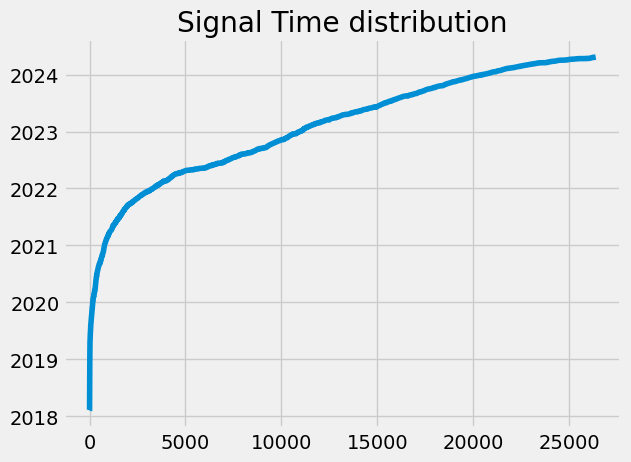

In [10]:
import re

if CFG.create_dataset:
    # check if train dataset has only columns that we expect
    cols = set(re.sub(r'_prev_\d+', '', c) for c in train_buy.columns)

    agg_funcs = ['amin', 'amax', 'mean', 'median', 'std']
    agg_cols = [c for c in cols if len(c.split('_')) > 2 and c.split('_')[-2] in agg_funcs]

    expected_cols = set(price_cols + higher_features + funding_cols + rsi_stoch_cols +
                        btcd_cols + btcdom_cols + agg_cols + ['atr', 'cci', 'sar', 'volume', 'pattern', 'target', 'ticker', 'ttype'])
    assert expected_cols == cols

    # check RSI and STOCH columns, their values must be in [0, 100] range 
    rsi_stoch_cols_ = [c for c in train_df.columns if ('rsi' in c or 'stoch' in c) and 'diff' not in c]
    for r_s_c in rsi_stoch_cols_:
        assert train_df[r_s_c].min() > -0.0001
        assert train_df[r_s_c].max() < 100.0001

    # check volume columns, their values must be >= 0
    vol_cols_ = [c for c in train_df.columns if 'volume' in c]
    for v_c in vol_cols_:
        assert train_df[v_c].min() >= 0

    # check funding columns, their period must be 8 hours
    funding_cols_ = [c for c in train_df.columns if c.startswith('funding')]
    for f_c in funding_cols_:
        num = ''.join([i for i in f_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 8 == 0

    # check BTC dominance columns, their values must be in [0, 100] range 
    # and their period must be 24 hours
    btcd_cols_ = [c for c in train_df.columns if c.startswith('btcd_') and 'volume' not in c]
    for b_c in btcd_cols_:
        pass_cycle = False
        for a_c in agg_funcs:
            if a_c in b_c:
                pass_cycle = True
                break
        if pass_cycle:
            continue
        # check values
        assert train_df[b_c].min() >= 0
        assert train_df[b_c].max() <= 100
        # check period
        num = ''.join([i for i in b_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 24 == 0

    # check the rest columns, their period must be 4 hours
    rest_cols_ = [c for c in train_df.columns if c not in funding_cols_ and c not in btcd_cols]
    for r_c in rest_cols_:
        num = ''.join([i for i in r_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 4 == 0

    # check if changing of source dataframe doesn't affect the resulting train dataframe
    test_df_buy_2 = train_buy[train_buy['time'].dt.hour.isin(buy_hours_to_save[0:1])]
    assert test_df_buy_1.shape == test_df_buy_2.shape
    test_df_sell_2 = train_sell[train_sell['time'].dt.hour.isin(sell_hours_to_save[0:1])]
    assert test_df_sell_1.shape == test_df_sell_2.shape

    # plot time values 
    train_df['time'].plot(title='Signal Time distribution')


### Test buy target corectness

In [11]:
prev_ticker = None

train_buy_ = train_buy[train_buy['ticker'] == 'MILOUSDT']

if CFG.create_dataset:
    for i in tqdm(range(train_buy.shape[0])):
        x = train_buy[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']
        if ticker != 'MILOUSDT':
            continue

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc('close')]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
        
        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            if pattern.startswith('STOCH'): 
                if last_price < close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                try:
                    assert first_signal > first_anti_signal
                except AssertionError:
                    pass

  0%|          | 0/15141 [00:00<?, ?it/s]

### Test sell target corectness

In [12]:
if CFG.create_dataset:
    for i in tqdm(range(train_sell.shape[0])):
        x = train_sell[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc('close')]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']

        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            if pattern.startswith('STOCH'):
                if last_price > close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

  0%|          | 0/11241 [00:00<?, ?it/s]

### Test pattern / target distribution

In [13]:
def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row['total'], row['count']
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

pvt = train_buy
pvt = pvt[['target', 'pattern', 'time']]
pvt['hour'] = pvt['time'].dt.hour
pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
pvt.rename(columns={'pattern': 'count'}, inplace=True)
pvt['pct'] = pvt['count'] / pvt['total']
pvt = pvt[pvt['target']==1]
pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

print('Buy')
display(pvt)
display(train_buy['ttype'].value_counts())
display(train_buy[['target', 'pattern']].value_counts())
display(train_buy[['target', 'pattern']].value_counts(normalize=True))

pvt = train_sell
pvt = pvt[['target', 'pattern', 'time']]
pvt['hour'] = pvt['time'].dt.hour
pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
pvt.rename(columns={'pattern': 'count'}, inplace=True)
pvt['pct'] = pvt['count'] / pvt['total']
pvt = pvt[pvt['target']==1]
pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

print('Sell')
display(pvt)
display(train_sell['ttype'].value_counts())
display(train_sell[['target', 'pattern']].value_counts())
display(train_sell[['target', 'pattern']].value_counts(normalize=True))

Buy


,hour,target,count,total,pct,trust_interval
1,0,1,957,1645,0.581763,"(0.558, 0.6055)"
3,1,1,1030,1866,0.551983,"(0.5295, 0.5744)"
5,2,1,945,1702,0.555229,"(0.5317, 0.5787)"
7,3,1,1022,1965,0.520102,"(0.4981, 0.5421)"
9,16,1,853,1626,0.524600,"(0.5005, 0.5488)"
11,17,1,837,1591,0.526084,"(0.5017, 0.5505)"
13,21,1,844,1613,0.523249,"(0.499, 0.5475)"
15,22,1,902,1668,0.540767,"(0.517, 0.5646)"
17,23,1,850,1465,0.580205,"(0.5551, 0.6053)"


buy    15141
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    8240
0       STOCH_RSI_Volume24    6901
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.544218
0       STOCH_RSI_Volume24    0.455782
dtype: float64

Sell


,hour,target,count,total,pct,trust_interval
1,1,1,524,1018,0.514735,"(0.4842, 0.5453)"
3,4,1,776,1490,0.520805,"(0.4956, 0.546)"
5,14,1,795,1488,0.534274,"(0.5091, 0.5595)"
7,16,1,635,1189,0.534062,"(0.5059, 0.5623)"
9,17,1,550,993,0.553877,"(0.5231, 0.5846)"
11,18,1,505,971,0.520082,"(0.4888, 0.5513)"
13,19,1,543,1044,0.520115,"(0.49, 0.5503)"
15,21,1,573,1082,0.529575,"(0.5, 0.5592)"
17,22,1,497,963,0.516096,"(0.4847, 0.5475)"
19,23,1,550,1003,0.548355,"(0.5177, 0.579)"


sell    11241
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    5948
0       STOCH_RSI_Volume24    5293
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.529134
0       STOCH_RSI_Volume24    0.470866
dtype: float64

# Data visualization

### Plot ratio of class 1 for every month

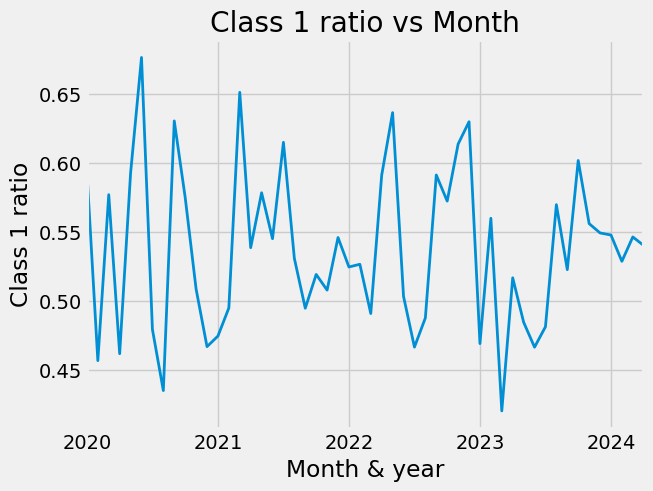

In [14]:
train_df['date_month'] = train_df['time'].dt.to_period('M')
group_df = train_df[train_df['time'].dt.year >= 2020]
ax = group_df.groupby('date_month')['target'].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel('Month & year')
ax.set_ylabel('Class 1 ratio')
ax.set_title('Class 1 ratio vs Month')
train_df = train_df.drop(columns='date_month')

### Visualize buy trades

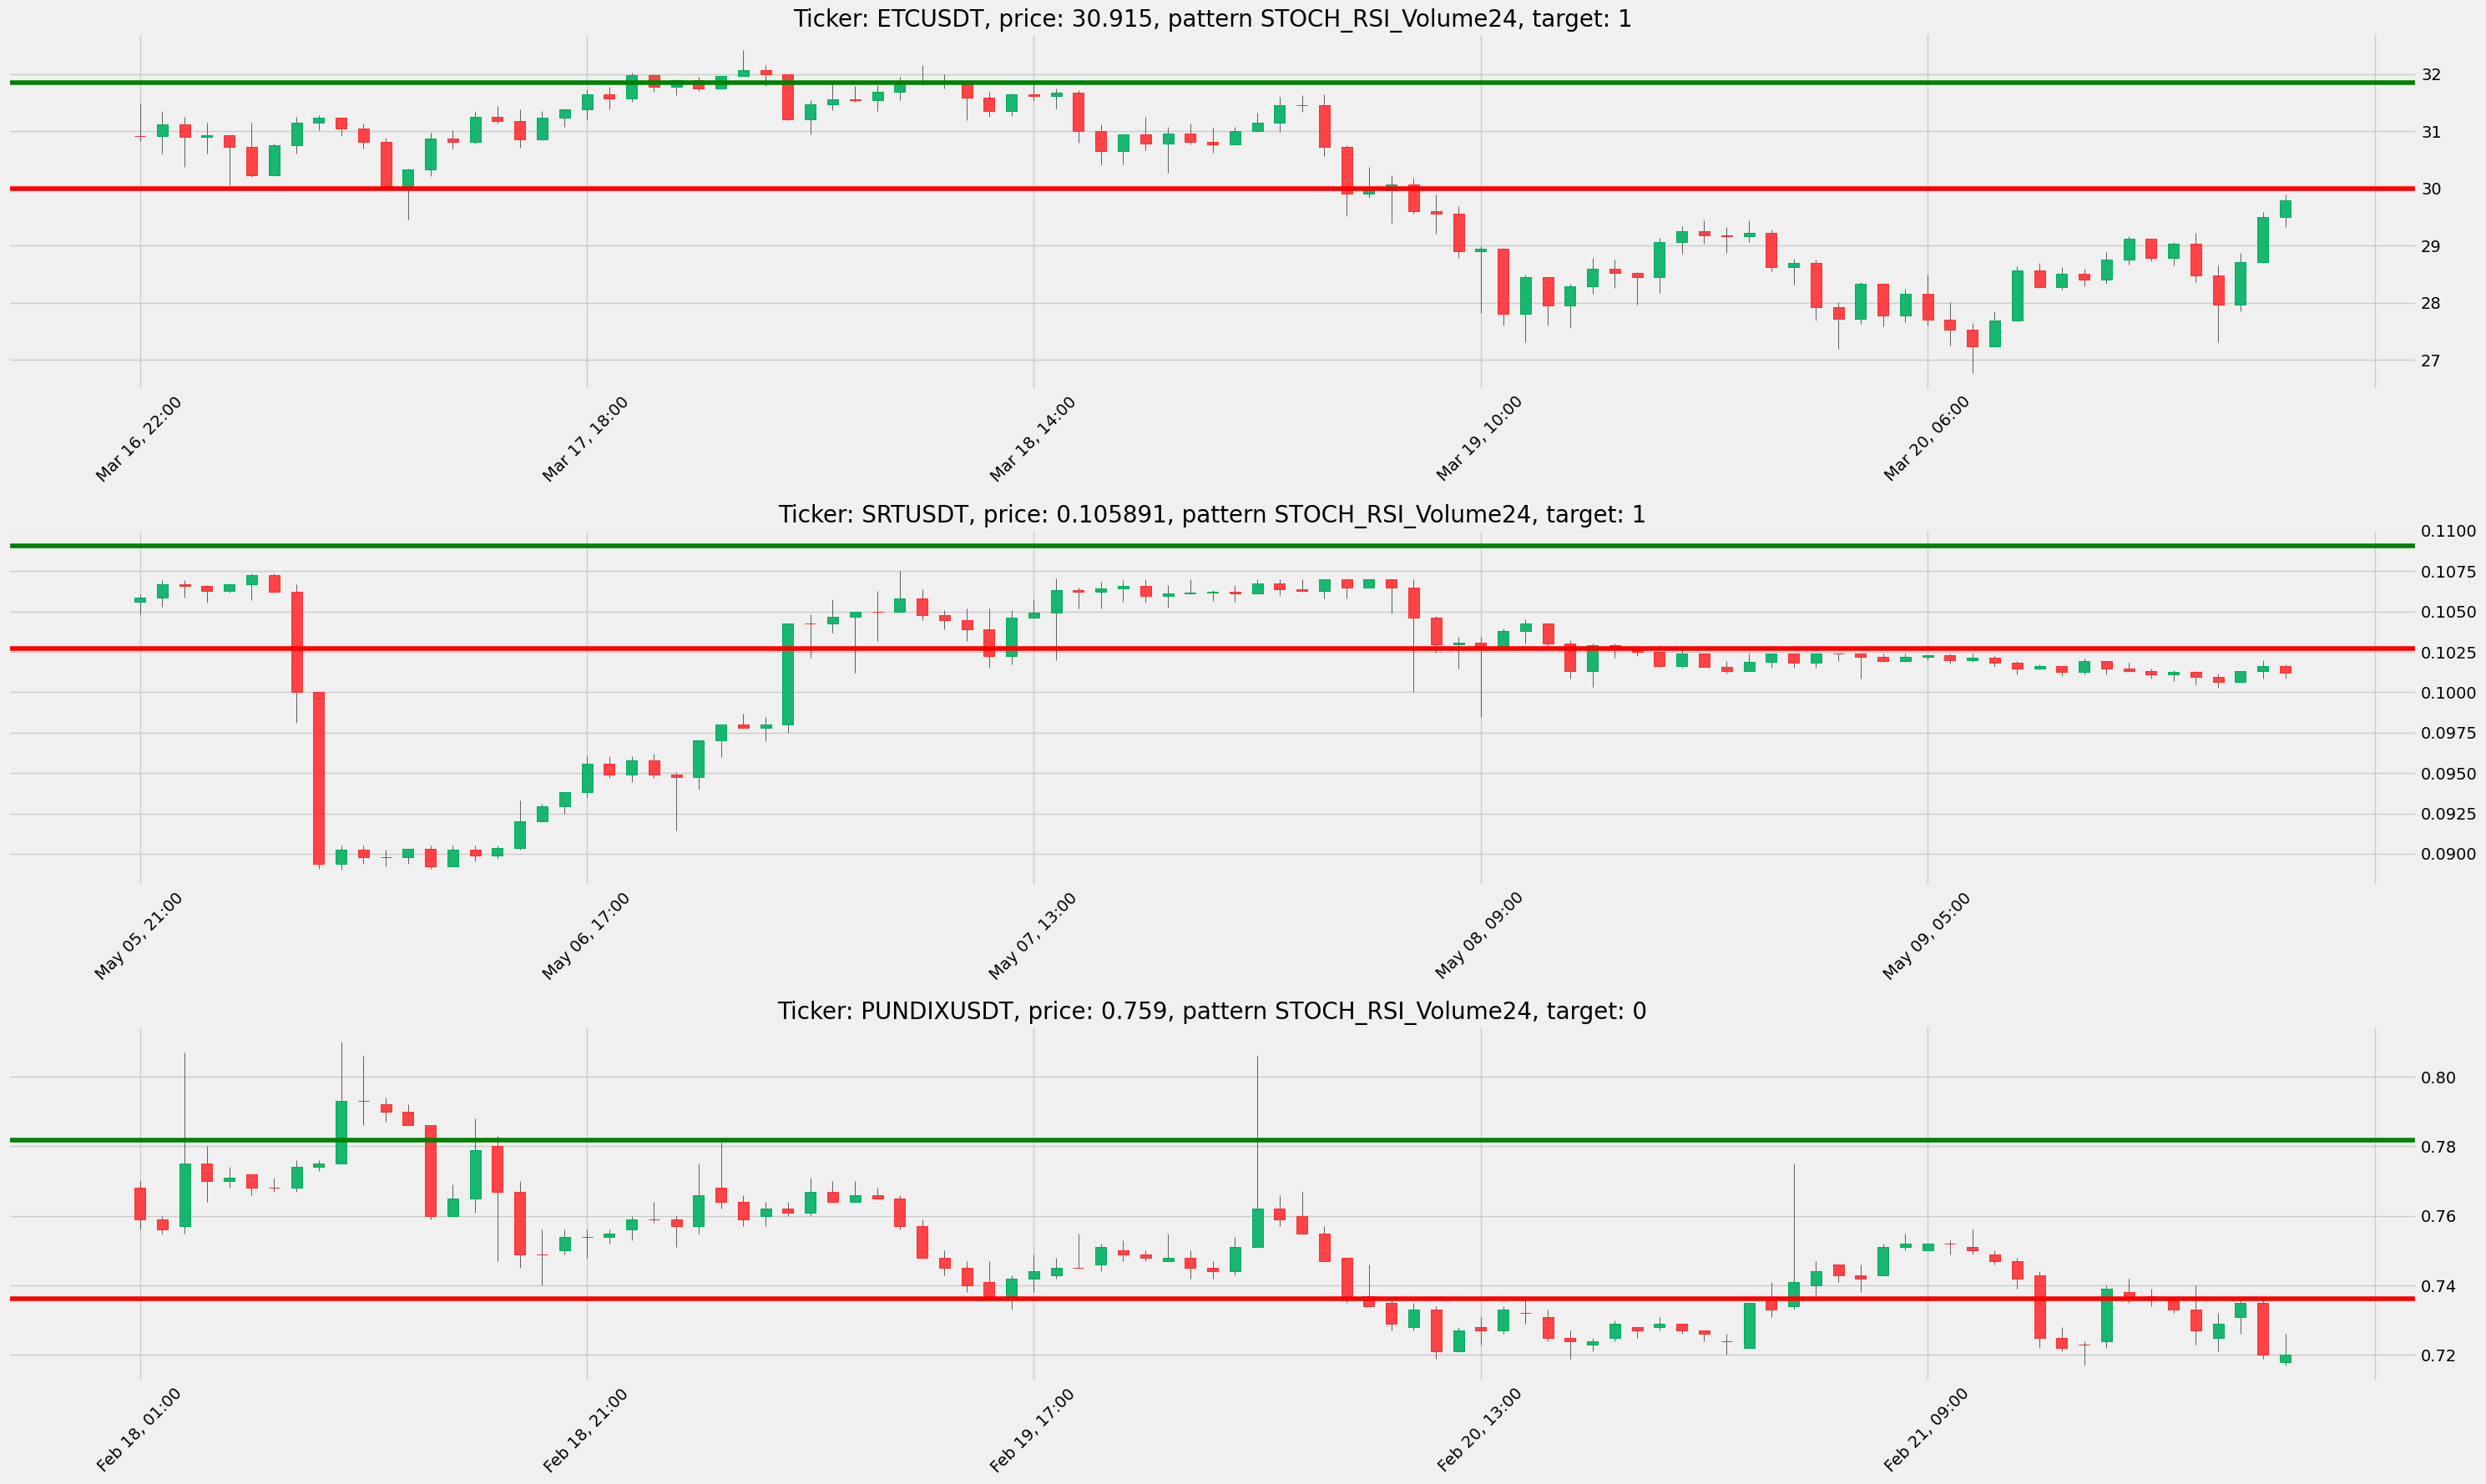

In [18]:
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:

    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)


    for i, row in test_buy.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]

        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize sell trades

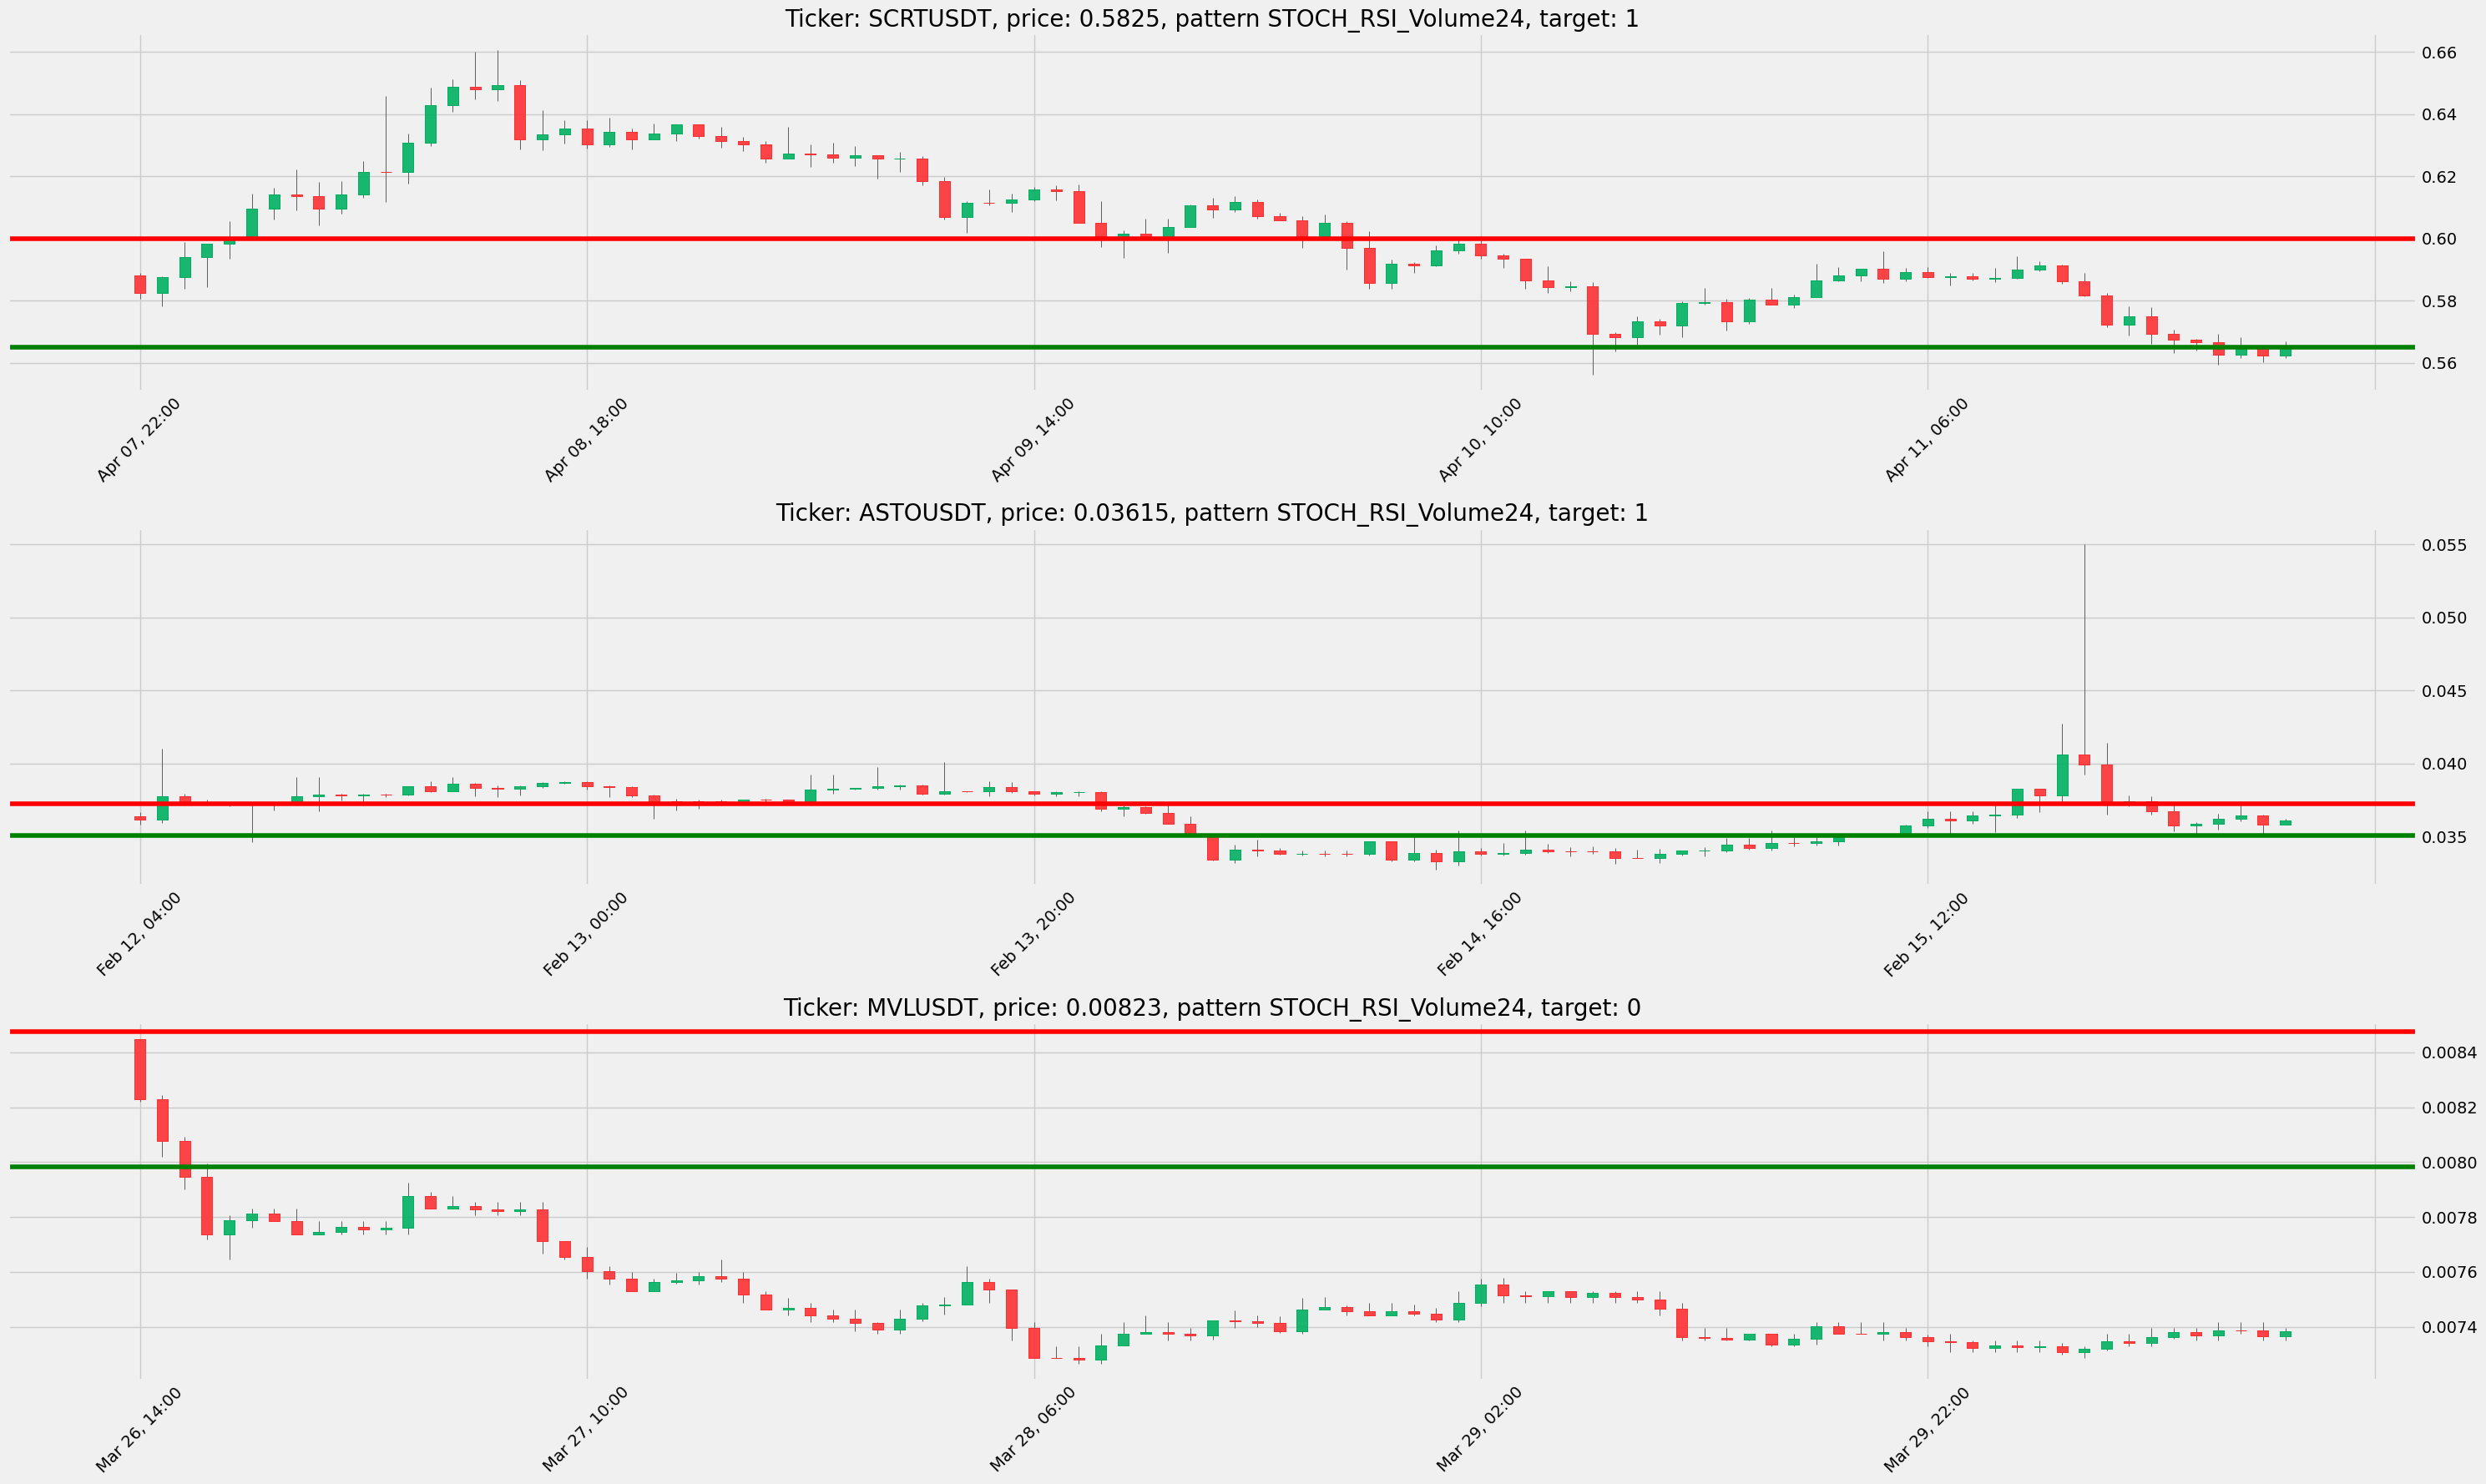

In [19]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize feature distributions

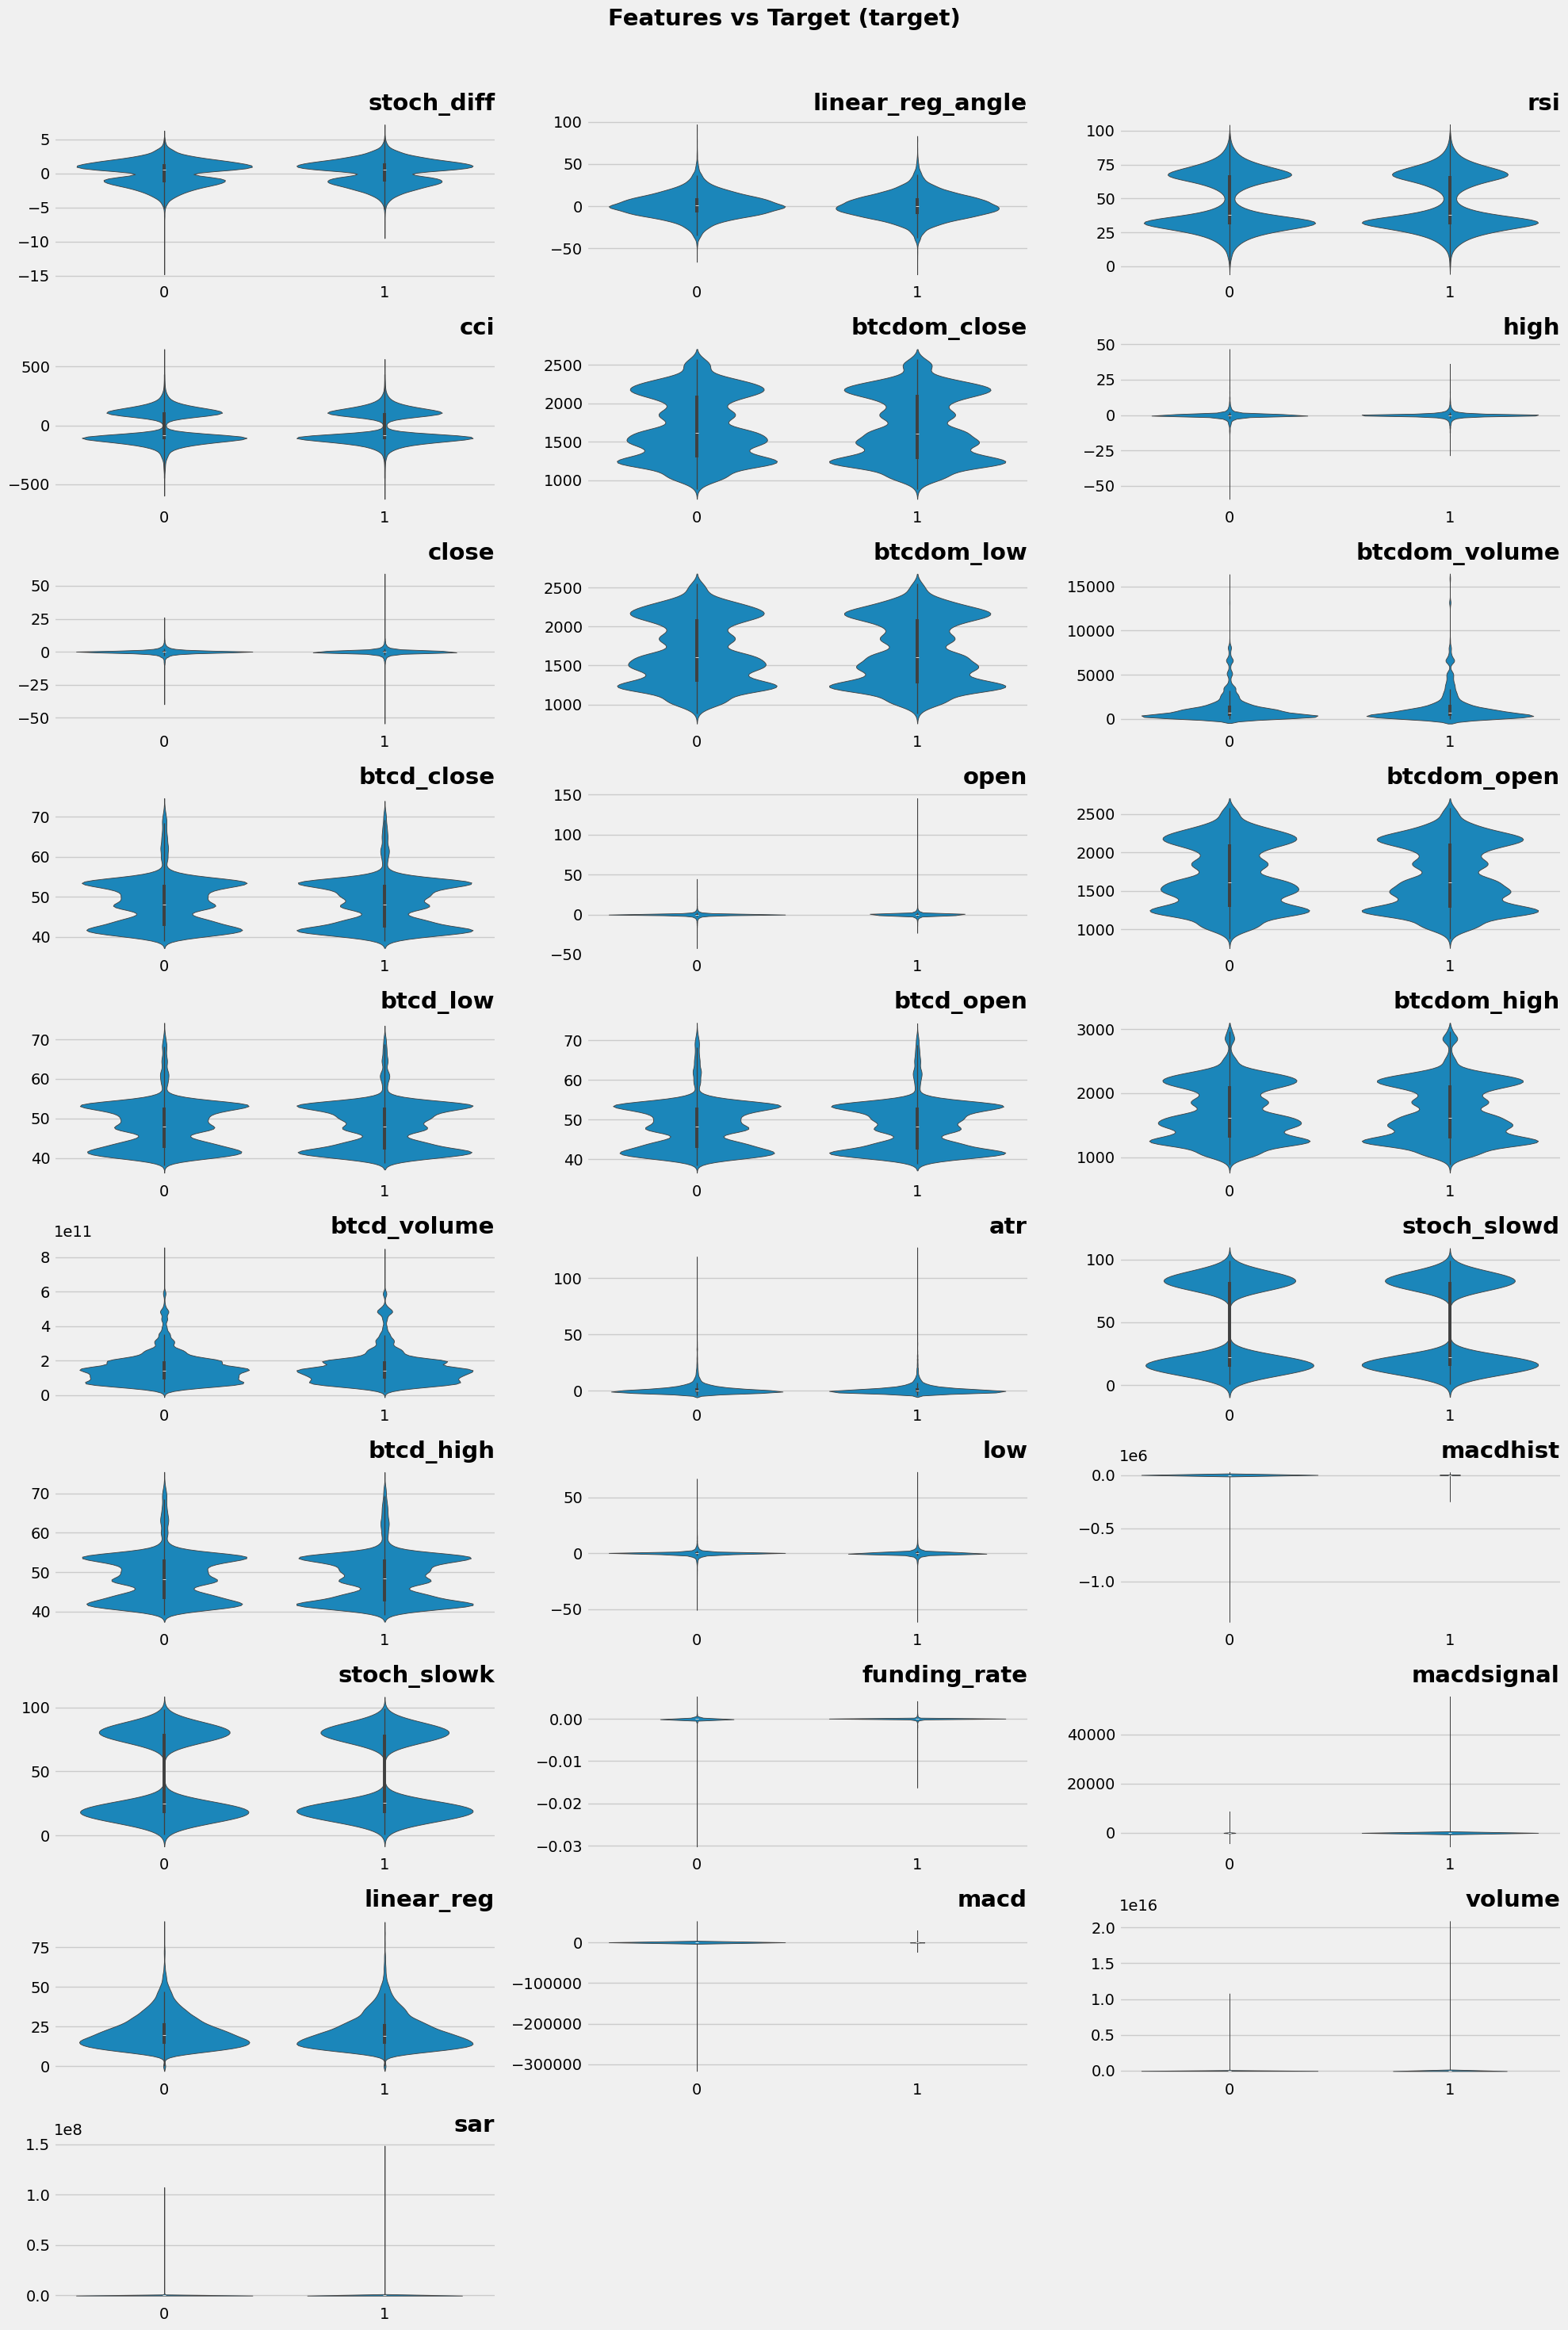

In [20]:
fi = pd.read_csv(f'model/feature_importance.csv')['Feature'].to_list()
cols = [c for c in fi if 'prev' not in c]
figsize = (20, 30)

def plot_target_violine(df, df_cols, n_rows, n_cols, target):
    fig = plt.figure(figsize=figsize)
    
    for idx, col in enumerate(df_cols):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        try:
            sns.violinplot(x=target, y=col, data=df)
        except ValueError:
            print(f"Can't find {col} in the dataframe")

        ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
        ax.set_xlabel(''); ax.spines['right'].set_visible(False)
        ax.set_title(f'{col}', loc='right', weight='bold', fontsize=21)

    
    fig.suptitle(f'Features vs Target ({target})\n\n\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
n_cols = 3
n_rows = len(cols) // n_cols + 1
plot_target_violine(train_df, cols, n_rows=n_rows, n_cols=n_cols, target='target')

### Show the last signals

In [21]:
x = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
x['ttype'] = 'buy'
y = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
y['ttype'] = 'sell'
x = pd.concat([x, y]).sort_values('time').reset_index(drop=True)
x.loc[x['pattern'] == 'STOCH_RSI_Volume24', ['time', 'ticker', 'ttype', 'pattern']].tail(35)

,time,ticker,ttype,pattern
84921,2024-04-23 14:00:00,JETTONUSDT,buy,STOCH_RSI_Volume24
84922,2024-04-23 14:00:00,VENOMUSDT,buy,STOCH_RSI_Volume24
84923,2024-04-23 14:00:00,DEGENBASEUSDT,buy,STOCH_RSI_Volume24
84924,2024-04-23 14:00:00,MKRUSDT,buy,STOCH_RSI_Volume24
84925,2024-04-23 14:00:00,NGLUSDT,buy,STOCH_RSI_Volume24
84926,2024-04-23 14:00:00,XETAUSDT,buy,STOCH_RSI_Volume24
84927,2024-04-23 15:00:00,MNTUSDT,buy,STOCH_RSI_Volume24
84928,2024-04-23 15:00:00,PSPSUSDT,buy,STOCH_RSI_Volume24
84929,2024-04-23 15:00:00,ENAUSDT,buy,STOCH_RSI_Volume24
84930,2024-04-23 15:00:00,JTOUSDT,buy,STOCH_RSI_Volume24


# Feature selection

### Select features with BORUTA feature importance

In [22]:
from shaphypetune import BoostBoruta
  
params = {
          'boosting_type': 'dart',
          'n_estimators': 1000,
          'learning_rate': 0.02,
          'max_depth': 10,
          'subsample' : 0.7,
          'colsample_bytree': 0.85,
          'num_leaves': 24,
          'verbosity': -1,
          'importance_type': 'gain',
          'max_bin': 255,
          'reg_alpha': 1e-6,
          'reg_lambda': 1e-7,
          'objective': 'binary',
          'metric': 'auc'
        }
features = [c for c in train_df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]


def ppv_npv_acc(y_true, y_pred):
    """ Calculate confusion matrix and return harmonic mean score of Positive Predictive Value (PPV, precisoin) and Negative Predictive Value (NPV) """
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    except ValueError:
        return 0
    return (tp + tn) / (tp + fp + tn + fn + 1e-8)

def ppv_npv_acc_lgbm(y_true, y_pred):
    """ Metric for LGBM """
    return 'ppv_npv_acc', ppv_npv_acc(y_true, y_pred), False


def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df['target'], df['time']

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
    eval_metric = 'logloss'

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f'Fold: {fold}')
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False, max_iter=1000)
        try:
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                      eval_metric='logloss', 
                      callbacks=[lgb.log_evaluation(100)])
        except RuntimeError:
            break

        boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values('importance')
    boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(train_df)

### Select features with permutation importance and GBM feature importance

In [23]:
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    
    for fold in range(CFG.n_repeats):
        print(f'Repeat {blu}#{fold+1}')

        X, y, time = df[features], df['target'], df['time']
        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric='logloss', 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(train_df, permut=True)

### RFE feature selection

In [24]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          'penalty': 'l2',
          'max_iter': 10000,
          'C': 1
        }

    scaler = StandardScaler()
    X, y = df[features], df['target']
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=5, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({'importance': selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({'index': 'Feature'}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(train_df)

### Combine importances and save them

In [25]:
if CFG.select_features:
    boruta_df_['rank'] = boruta_df_['importance'].rank()
    perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
    rfe_df_['rank'] = rfe_df_['importance']
    feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

    fi = pd.concat([perm_df_[['Feature','rank']], feature_importances_[['Feature','rank']], rfe_df_[['Feature','rank']],
                    boruta_df_[['Feature','rank']]])
    fi = fi.groupby('Feature')['rank'].sum().sort_values().reset_index()
    fi.to_csv(f'model/feature_importance.csv')
else:
    fi = pd.read_csv(f'model/feature_importance.csv')

# Train

### Load selected features

In [26]:
def exclude_corr_features(features, corr_thresh):
    features_to_select = features.copy()
    correlations = train_df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']] 
    correlations.columns = ['feature_1', 'feature_2', 'corr']

    correlations = pd.merge(left=correlations, right=fi, how='left', left_on='feature_1', right_on='Feature')
    correlations = correlations.drop(columns='Feature')
    correlations = correlations.sort_values(['corr', 'rank'], ascending=[False, True])
    correlations = correlations[::2]

    features_to_exclude = set()
    correlations = correlations[correlations['corr'] > corr_thresh]

    for _, row in correlations.iterrows():
        feature_1 = row['feature_1']
        feature_2 = row['feature_2']

        if feature_1 in features_to_exclude:
            continue

        features_to_exclude.add(feature_2)

    return features_to_exclude


def prepare_features(fi, feature_num, corr_thresh):
    ''' Get features, sort them by their time appearance and return for using in train and inference'''
    # exclude some features 
    fi = fi['Feature']
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == 'volume_24':
            feature_dict[0].append(f)
            continue
        period = f.split('_')
        if period[-1].isdigit() and period[-2] == 'prev':
            feature_dict[int(period[-1])].append('_'.join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f'_prev_{item[0]}' for i in item[1]])
        else:
            features.extend([i for i in item[1]])
    
    # select only features with low correlation
    features_to_exclude = exclude_corr_features(features, corr_thresh)
    features = [f for f in features if f not in features_to_exclude]
    features = list(features) + ['weekday']
    
    # remove highly correlated features from the feature dict
    feature_dict['features'] = features

    for item in feature_dict.items():
        if not isinstance(item[0], int):
            continue

        features_to_remove = list()

        for f in item[1]:
            if item[0] > 0:
                f_ = f'{f}_prev_{item[0]}'
            else:
                f_ = f
            
            if f_ not in features:
                assert f_ in features_to_exclude
                features_to_remove.append(f)
        
        feature_dict[item[0]] = [f for f in feature_dict[item[0]] if f not in features_to_remove]

    # remove empty lists from feature_dict
    empty_list_keys = list()
    
    for key in feature_dict:
        if not feature_dict[key]:
            empty_list_keys.append(key)
            
    for key in empty_list_keys:
        del feature_dict[key]

    return features, feature_dict

feature_num = 470 # 569
corr_thresh = 0.9654300044402008 # 0.9895527773275344

train_df['weekday'] = train_df['time'].dt.weekday
fi = pd.read_csv('model/feature_importance.csv')
features, feature_dict = prepare_features(fi, feature_num, corr_thresh)
assert len(features) == len(set(features))

display(features, len(features))

['stoch_diff',
 'linear_reg_angle',
 'rsi',
 'cci',
 'btcdom_close',
 'high',
 'close',
 'btcdom_volume',
 'open',
 'btcd_volume',
 'cci_prev_4',
 'btcdom_volume_prev_4',
 'stoch_diff_prev_4',
 'linear_reg_angle_prev_4',
 'volume_prev_4',
 'high_prev_4',
 'close_prev_4',
 'rsi_prev_4',
 'stoch_slowk_prev_4',
 'rsi_prev_8',
 'stoch_slowd_prev_8',
 'linear_reg_angle_prev_8',
 'stoch_diff_prev_8',
 'close_prev_8',
 'low_prev_12',
 'stoch_slowk_prev_12',
 'close_prev_12',
 'cci_prev_12',
 'linear_reg_angle_prev_12',
 'rsi_prev_12',
 'low_prev_16',
 'atr_prev_16',
 'close_prev_16',
 'btcdom_volume_prev_20',
 'stoch_slowk_prev_20',
 'atr_prev_20',
 'stoch_diff_prev_20',
 'close_prev_20',
 'btcd_volume_prev_24',
 'open_prev_24',
 'btcdom_volume_prev_24',
 'rsi_prev_24',
 'high_prev_24',
 'atr_prev_24',
 'close_prev_24',
 'cci_prev_24',
 'stoch_slowk_prev_24',
 'stoch_diff_prev_24',
 'btcdom_volume_prev_28',
 'stoch_diff_prev_28',
 'close_prev_28',
 'low_prev_28',
 'rsi_prev_28',
 'atr_prev_28

387

### Functions for train and optimization

In [27]:
val_idxs = list()
score_list = list()
with open(f'model/bybit_tickers.json', 'r') as f:
    bybit_tickers = json.load(f)
df_len = train_df.shape[0]

def conf_ppv_npv_acc_score(y, oof, low_bound, high_bound):
    """ Consider only high confident objects and low confident objects for PPV and NPV score calculation """
    pred_conf = np.zeros_like(oof)
    pred_conf[oof >= high_bound] = 1
    pred_conf = pred_conf[(oof >= high_bound) | (oof <= low_bound)]
    y_conf = y.values.reshape(-1,1)[(oof >= high_bound) | (oof <= low_bound)]
    if y_conf.shape[0] == 0:
        return 0, 0, 0
    return ppv_npv_acc(y_conf, pred_conf), y_conf.shape[0], y_conf.shape[0]/y.shape[0]

def model_train(df, features, params, n_folds, low_bound, high_bound, train_test, max_train_size=None, verbose=False): 
    X, time = df[features], df['time']
    y = df['target']
    
    if train_test == 'fold':
        oof = np.zeros([len(df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=max_train_size, n_splits=n_folds, test_size=(len(df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_time = time[fit_idx].max() + pd.to_timedelta(96, unit='h')
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_time) & (df['ticker'].isin(bybit_tickers))].index.tolist()
            
            val_idxs.extend(val_idx)
            
            if verbose:
                print(f'Fold #{fold + 1}')
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts(normalize=True))
                display(df.loc[val_idx[0], 'time'])
                display(df.loc[val_idx[-1], 'time'])
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric='logloss', callbacks=callbacks)

            val_preds = model_lgb.predict_proba(X_val)
        
            val_score = log_loss(y_val, val_preds)
            ppv_npv_acc_score, conf_obj_num, conf_obj_pct = conf_ppv_npv_acc_score(y_val, val_preds[:, 1], low_bound, high_bound)
            score_list.append(ppv_npv_acc_score)
            if verbose:
                print(f'Logloss: {val_score}, Confident objects score: {ppv_npv_acc_score}\n'
                      f'Number of confident objects {conf_obj_num}, % of confident objects: {conf_obj_pct}\n'
                      f'Number of profitable objects: {round((2 * ppv_npv_acc_score -  1) * conf_obj_num)}')
            oof[val_idx, 0] = val_preds[:,1]
        
        return oof, model_lgb, sorted(list(set(val_idxs)))
    elif train_test == 'full' or train_test == 'inference':
        print('Train on full data')
        X, y = df[features], df['target']
        
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, eval_set=[(X, y)], eval_metric='logloss', callbacks = [lgb.log_evaluation(100)])
        
        return np.zeros([df.shape[0], 1]), model_lgb, None

def objective(trial):
    params = {
        # Main parameters
#                     'device': 'gpu',
#                     'gpu_platform_id': 0,
#                     'gpu_device_id': 0,
        'objective': 'binary',
        'metric': 'average_precison',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt']), # ['dart', 'goss', 'gbdt']),   !!!
        # Hyperparamters (in order of importance decreasing)
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),  # max number of trees in model
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 3e-1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        'max_depth': trial.suggest_int('max_depth', 4, 10), # tree max depth 
         # decrease to deal with overfit
        'num_leaves': trial.suggest_int('num_leaves', 4, 512),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        'max_bin': trial.suggest_int('max_bin', 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        'subsample_freq': 1, # Perform bagging at every k iteration, alias: bagging_freq

        # 'subsample_for_bin': 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                       # to larger value will give better training result but may increase train time 
        # 'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                         # categorical features, especially for 
                                                                         # categories with few data                                  
        'is_unbalance': trial.suggest_categorical('is_unbalance', [True, False]),                                            
        'verbose': -1,
        'importance_type': 'gain',
        'high_bound': trial.suggest_float('high_bound', 0.5, 0.65),
        'low_bound': trial.suggest_float('low_bound', 0.0, 0.1),
        'feature_num': trial.suggest_int('feature_num', 30, 600),
        'corr_thresh': trial.suggest_float('corr_thresh', 0.5, 0.99)
    }
    
    if params['boosting_type'] != 'goss':
        params['subsample'] = trial.suggest_float('subsample', 0.3, 0.9)

    if params['is_unbalance'] == 'True':
        params['class_weight'] = trial.suggest_categorical('class_weight', ['balanced', None]), 

    high_bound = params['high_bound']
    del params['high_bound']

    low_bound = params['low_bound']
    del params['low_bound']

    corr_thresh = params['corr_thresh']
    del params['corr_thresh']
    
    fi = pd.read_csv(f'model/feature_importance.csv')
    feature_num = params['feature_num']
    del params['feature_num']
    
    train_df['weekday'] = train_df['time'].dt.weekday
    features, _ = prepare_features(fi, feature_num, corr_thresh)
    
    oof, __, val_idxs = model_train(train_df[train_df['time'] < CFG.last_date], features, params, max_train_size=None, 
                                    n_folds=8, low_bound=low_bound, high_bound=high_bound, 
                                    train_test='fold', verbose=False)
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_conf_score, oof_conf_obj_num, oof_conf_obj_pct = conf_ppv_npv_acc_score(y, oof, low_bound, high_bound)
    oof_val_score = log_loss(y, oof)
    res = oof_conf_obj_num * (oof_conf_score-0.575) * 100
    # save dataframe with additional information
    df_optuna_more_info = pd.read_csv('optuna/optuna_lgbm_info.csv')
    profit_objects = round(oof_conf_obj_num * (2 * oof_conf_score - 1))
    tmp = pd.DataFrame({'value': [res], 'oof_conf_score': [oof_conf_score], 
                        'profit_objects': [profit_objects], 'oof_val_score': [oof_val_score], 
                        'oof_conf_obj_num': [oof_conf_obj_num], 'oof_conf_obj_pct': [oof_conf_obj_pct], 
                        })
    df_optuna_more_info = pd.concat([df_optuna_more_info, tmp])
    df_optuna_more_info.to_csv('optuna/optuna_lgbm_info.csv', index=False)
    return res

### Train / optimize process

In [29]:
params = {
    'boosting_type': 'gbdt',
    'n_estimators': 2199,
    'learning_rate': 0.0021888119746491506,
    'reg_alpha': 0.0002981624556905146,
    'reg_lambda': 3.7892507774352097e-07,
    'max_depth': 4,
    'num_leaves': 107,
    'colsample_bytree': 0.8672690606321763,
    'max_bin': 241,
    'is_unbalance': False,
    'subsample': 0.6439343950294815,
    'subsample_freq': 1,
    'objective': 'binary',
    'importance_type': 'gain',
    'metric': 'average_precison',
    'verbosity': -1
}

train_test = 'test' # fold, inference, test
max_train_size = None

high_bound = 0.6203827236837305 # 0.51
low_bound = 0 #.0413800710255353

if CFG.optimize:
    df_optuna_more_info = pd.DataFrame(columns=['value', 'oof_conf_score', 'profit_objects', 
                                                'oof_val_score', 'oof_conf_obj_num', 'oof_conf_obj_pct'])
    df_optuna_more_info.to_csv('optuna/optuna_lgbm_info.csv', index=False)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=1000)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values('value', ascending=False)
    df_optuna.to_csv(f'optuna/optuna_lgbm.csv')

    display(df_optuna.head(10))
elif train_test == 'fold':
    oof, _, val_idxs = model_train(train_df[train_df['time'] < CFG.last_date], features, params, n_folds=9, low_bound=low_bound, high_bound=high_bound, 
                                   train_test=train_test, max_train_size=max_train_size, verbose=True)
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_val_score = log_loss(y, oof)
    oof_conf_score, oof_conf_obj_num, oof_conf_obj_pct = conf_ppv_npv_acc_score(y, oof, low_bound, high_bound)

    print(f'Total fold Logloss: {oof_val_score}, Total confident objects score: {oof_conf_score}\n'
            f'Number of confident objects: {oof_conf_obj_num}, Total % of confident objects: {oof_conf_obj_pct}\n' 
            f'Number of profitable objects: {round(( 2 * oof_conf_score - 1) * oof_conf_obj_num)}')
elif train_test == 'inference': 
    oof, model, val_idxs = model_train(train_df, features, params, n_folds=1, low_bound=low_bound, 
                                       high_bound=high_bound, train_test=train_test, verbose=True)
    joblib.dump(model, f'model/lgbm.pkl')
    # save feature dictionary for further inference
    with open(f'model/features.json', 'w') as f:
        json.dump(feature_dict, f)

In [30]:
# Training with 387 features
# Fold #1
# 1    0.553066
# 0    0.446934
# Name: target, dtype: float64Timestamp('2022-09-05 23:00:00')Timestamp('2024-04-14 02:00:00')
# [100]	training's binary_logloss: 0.67555	valid_1's binary_logloss: 0.687585
# [200]	training's binary_logloss: 0.663418	valid_1's binary_logloss: 0.687801
# [300]	training's binary_logloss: 0.653303	valid_1's binary_logloss: 0.687987
# [400]	training's binary_logloss: 0.644629	valid_1's binary_logloss: 0.688283
# [500]	training's binary_logloss: 0.636965	valid_1's binary_logloss: 0.688467
# [600]	training's binary_logloss: 0.630304	valid_1's binary_logloss: 0.688646
# [700]	training's binary_logloss: 0.624285	valid_1's binary_logloss: 0.689114
# [800]	training's binary_logloss: 0.618825	valid_1's binary_logloss: 0.689669
# [900]	training's binary_logloss: 0.613587	valid_1's binary_logloss: 0.69008
# [1000]	training's binary_logloss: 0.608676	valid_1's binary_logloss: 0.69047
# [1100]	training's binary_logloss: 0.604135	valid_1's binary_logloss: 0.691047
# [1200]	training's binary_logloss: 0.599563	valid_1's binary_logloss: 0.691683
# [1300]	training's binary_logloss: 0.59518	valid_1's binary_logloss: 0.692345
# [1400]	training's binary_logloss: 0.59088	valid_1's binary_logloss: 0.692958
# [1500]	training's binary_logloss: 0.586842	valid_1's binary_logloss: 0.693482
# [1600]	training's binary_logloss: 0.58274	valid_1's binary_logloss: 0.694142
# [1700]	training's binary_logloss: 0.578907	valid_1's binary_logloss: 0.694806
# [1800]	training's binary_logloss: 0.575149	valid_1's binary_logloss: 0.695349
# [1900]	training's binary_logloss: 0.571378	valid_1's binary_logloss: 0.695782
# [2000]	training's binary_logloss: 0.567805	valid_1's binary_logloss: 0.69642
# [2100]	training's binary_logloss: 0.56416	valid_1's binary_logloss: 0.696848
# Logloss: 0.6974799941460057, Confident objects score: 0.5681511470969821
# Number of confident objects 3705, % of confident objects: 0.41921249151391715
# Number of profitable objects: 505
# Fold #2
# 1    0.541893
# 0    0.458107
# Name: target, dtype: float64Timestamp('2022-12-20 02:00:00')Timestamp('2024-04-14 02:00:00')
# [100]	training's binary_logloss: 0.676396	valid_1's binary_logloss: 0.689929
# [200]	training's binary_logloss: 0.665809	valid_1's binary_logloss: 0.690178
# [300]	training's binary_logloss: 0.656915	valid_1's binary_logloss: 0.690109
# [400]	training's binary_logloss: 0.648919	valid_1's binary_logloss: 0.690023
# [500]	training's binary_logloss: 0.642362	valid_1's binary_logloss: 0.69007
# [600]	training's binary_logloss: 0.636297	valid_1's binary_logloss: 0.690155
# [700]	training's binary_logloss: 0.630846	valid_1's binary_logloss: 0.690733
# [800]	training's binary_logloss: 0.62592	valid_1's binary_logloss: 0.691104
# [900]	training's binary_logloss: 0.621228	valid_1's binary_logloss: 0.69154
# [1000]	training's binary_logloss: 0.616831	valid_1's binary_logloss: 0.691802
# [1100]	training's binary_logloss: 0.612695	valid_1's binary_logloss: 0.692049
# [1200]	training's binary_logloss: 0.608582	valid_1's binary_logloss: 0.692372
# [1300]	training's binary_logloss: 0.604763	valid_1's binary_logloss: 0.692879
# [1400]	training's binary_logloss: 0.600888	valid_1's binary_logloss: 0.693067
# [1500]	training's binary_logloss: 0.597303	valid_1's binary_logloss: 0.693404
# [1600]	training's binary_logloss: 0.593708	valid_1's binary_logloss: 0.693825
# [1700]	training's binary_logloss: 0.59025	valid_1's binary_logloss: 0.694021
# [1800]	training's binary_logloss: 0.586835	valid_1's binary_logloss: 0.694299
# [1900]	training's binary_logloss: 0.583566	valid_1's binary_logloss: 0.694551
# [2000]	training's binary_logloss: 0.580364	valid_1's binary_logloss: 0.694858
# [2100]	training's binary_logloss: 0.577164	valid_1's binary_logloss: 0.695063
# Logloss: 0.6951293346549227, Confident objects score: 0.5822168087674291
# Number of confident objects 2463, % of confident objects: 0.31846392552366176
# Number of profitable objects: 405
# Fold #3
# 1    0.549211
# 0    0.450789
# Name: target, dtype: float64Timestamp('2023-03-24 04:00:00')Timestamp('2024-04-14 02:00:00')
# [100]	training's binary_logloss: 0.67695	valid_1's binary_logloss: 0.687826
# [200]	training's binary_logloss: 0.666605	valid_1's binary_logloss: 0.687303
# [300]	training's binary_logloss: 0.657799	valid_1's binary_logloss: 0.686652
# [400]	training's binary_logloss: 0.650531	valid_1's binary_logloss: 0.686307
# [500]	training's binary_logloss: 0.644343	valid_1's binary_logloss: 0.686196
# [600]	training's binary_logloss: 0.638558	valid_1's binary_logloss: 0.686115
# [700]	training's binary_logloss: 0.633385	valid_1's binary_logloss: 0.686424
# [800]	training's binary_logloss: 0.628654	valid_1's binary_logloss: 0.686614
# [900]	training's binary_logloss: 0.62425	valid_1's binary_logloss: 0.686875
# [1000]	training's binary_logloss: 0.620123	valid_1's binary_logloss: 0.687013
# [1100]	training's binary_logloss: 0.616125	valid_1's binary_logloss: 0.687427
# [1200]	training's binary_logloss: 0.612188	valid_1's binary_logloss: 0.687687
# [1300]	training's binary_logloss: 0.608558	valid_1's binary_logloss: 0.688045
# [1400]	training's binary_logloss: 0.604921	valid_1's binary_logloss: 0.688367
# [1500]	training's binary_logloss: 0.601679	valid_1's binary_logloss: 0.688648
# [1600]	training's binary_logloss: 0.598367	valid_1's binary_logloss: 0.688952
# [1700]	training's binary_logloss: 0.595074	valid_1's binary_logloss: 0.689163
# [1800]	training's binary_logloss: 0.591897	valid_1's binary_logloss: 0.689258
# [1900]	training's binary_logloss: 0.588763	valid_1's binary_logloss: 0.689412
# [2000]	training's binary_logloss: 0.58579	valid_1's binary_logloss: 0.689435
# [2100]	training's binary_logloss: 0.582817	valid_1's binary_logloss: 0.689505
# Logloss: 0.6897219657989503, Confident objects score: 0.6032849020808384
# Number of confident objects 1583, % of confident objects: 0.23786626596543953
# Number of profitable objects: 327
# Fold #4
# 1    0.559905
# 0    0.440095
# Name: target, dtype: float64Timestamp('2023-05-28 23:00:00')Timestamp('2024-04-14 02:00:00')
# [100]	training's binary_logloss: 0.678869	valid_1's binary_logloss: 0.687208
# [200]	training's binary_logloss: 0.669304	valid_1's binary_logloss: 0.687853
# [300]	training's binary_logloss: 0.661187	valid_1's binary_logloss: 0.688524
# [400]	training's binary_logloss: 0.654273	valid_1's binary_logloss: 0.688913
# [500]	training's binary_logloss: 0.648408	valid_1's binary_logloss: 0.689211
# [600]	training's binary_logloss: 0.642988	valid_1's binary_logloss: 0.689088
# [700]	training's binary_logloss: 0.638137	valid_1's binary_logloss: 0.689207
# [800]	training's binary_logloss: 0.63376	valid_1's binary_logloss: 0.689128
# [900]	training's binary_logloss: 0.629534	valid_1's binary_logloss: 0.689195
# [1000]	training's binary_logloss: 0.625561	valid_1's binary_logloss: 0.689546
# [1100]	training's binary_logloss: 0.621908	valid_1's binary_logloss: 0.689852
# [1200]	training's binary_logloss: 0.6183	valid_1's binary_logloss: 0.689879
# [1300]	training's binary_logloss: 0.614899	valid_1's binary_logloss: 0.689856
# [1400]	training's binary_logloss: 0.611603	valid_1's binary_logloss: 0.690119
# [1500]	training's binary_logloss: 0.608474	valid_1's binary_logloss: 0.689811
# [1600]	training's binary_logloss: 0.605373	valid_1's binary_logloss: 0.689963
# [1700]	training's binary_logloss: 0.602431	valid_1's binary_logloss: 0.690108
# [1800]	training's binary_logloss: 0.599486	valid_1's binary_logloss: 0.690339
# [1900]	training's binary_logloss: 0.596609	valid_1's binary_logloss: 0.690805
# [2000]	training's binary_logloss: 0.59392	valid_1's binary_logloss: 0.690766
# [2100]	training's binary_logloss: 0.591137	valid_1's binary_logloss: 0.690783
# Logloss: 0.6909285182141214, Confident objects score: 0.7179487179257068
# Number of confident objects 312, % of confident objects: 0.05680990531682447
# Number of profitable objects: 136
# Fold #5
# 1    0.570106
# 0    0.429894
# Name: target, dtype: float64Timestamp('2023-08-19 14:00:00')Timestamp('2024-04-14 02:00:00')
# [100]	training's binary_logloss: 0.680718	valid_1's binary_logloss: 0.685502
# [200]	training's binary_logloss: 0.671949	valid_1's binary_logloss: 0.685142
# [300]	training's binary_logloss: 0.664499	valid_1's binary_logloss: 0.684385
# [400]	training's binary_logloss: 0.658277	valid_1's binary_logloss: 0.683571
# [500]	training's binary_logloss: 0.652881	valid_1's binary_logloss: 0.683109
# [600]	training's binary_logloss: 0.647962	valid_1's binary_logloss: 0.682568
# [700]	training's binary_logloss: 0.64348	valid_1's binary_logloss: 0.682387
# [800]	training's binary_logloss: 0.639306	valid_1's binary_logloss: 0.682007
# [900]	training's binary_logloss: 0.635578	valid_1's binary_logloss: 0.68202
# [1000]	training's binary_logloss: 0.631863	valid_1's binary_logloss: 0.681872
# [1100]	training's binary_logloss: 0.628482	valid_1's binary_logloss: 0.681859
# [1200]	training's binary_logloss: 0.625123	valid_1's binary_logloss: 0.681686
# [1300]	training's binary_logloss: 0.62197	valid_1's binary_logloss: 0.681797
# [1400]	training's binary_logloss: 0.618929	valid_1's binary_logloss: 0.68188
# [1500]	training's binary_logloss: 0.616096	valid_1's binary_logloss: 0.681889
# [1600]	training's binary_logloss: 0.613276	valid_1's binary_logloss: 0.681861
# [1700]	training's binary_logloss: 0.610552	valid_1's binary_logloss: 0.681934
# [1800]	training's binary_logloss: 0.607846	valid_1's binary_logloss: 0.681961
# [1900]	training's binary_logloss: 0.605205	valid_1's binary_logloss: 0.682013
# [2000]	training's binary_logloss: 0.602643	valid_1's binary_logloss: 0.682081
# [2100]	training's binary_logloss: 0.600088	valid_1's binary_logloss: 0.682274
# Logloss: 0.6823972533194677, Confident objects score: 0.6657223795845404
# Number of confident objects 353, % of confident objects: 0.07970196432603296
# Number of profitable objects: 117
# Fold #6
# 1    0.570359
# 0    0.429641
# Name: target, dtype: float64Timestamp('2023-10-25 21:00:00')Timestamp('2024-04-14 02:00:00')
# [100]	training's binary_logloss: 0.681135	valid_1's binary_logloss: 0.683927
# [200]	training's binary_logloss: 0.673058	valid_1's binary_logloss: 0.682611
# [300]	training's binary_logloss: 0.666192	valid_1's binary_logloss: 0.681495
# [400]	training's binary_logloss: 0.660601	valid_1's binary_logloss: 0.68076
# [500]	training's binary_logloss: 0.655592	valid_1's binary_logloss: 0.680001
# [600]	training's binary_logloss: 0.651	valid_1's binary_logloss: 0.679382
# [700]	training's binary_logloss: 0.646835	valid_1's binary_logloss: 0.679006
# [800]	training's binary_logloss: 0.642963	valid_1's binary_logloss: 0.678706
# [900]	training's binary_logloss: 0.63945	valid_1's binary_logloss: 0.678535
# [1000]	training's binary_logloss: 0.636117	valid_1's binary_logloss: 0.678466
# [1100]	training's binary_logloss: 0.632936	valid_1's binary_logloss: 0.678316
# [1200]	training's binary_logloss: 0.629816	valid_1's binary_logloss: 0.677996
# [1300]	training's binary_logloss: 0.626908	valid_1's binary_logloss: 0.677904
# [1400]	training's binary_logloss: 0.623988	valid_1's binary_logloss: 0.677884
# [1500]	training's binary_logloss: 0.621254	valid_1's binary_logloss: 0.677947
# [1600]	training's binary_logloss: 0.61857	valid_1's binary_logloss: 0.677868
# [1700]	training's binary_logloss: 0.616022	valid_1's binary_logloss: 0.677848
# [1800]	training's binary_logloss: 0.613442	valid_1's binary_logloss: 0.677709
# [1900]	training's binary_logloss: 0.610902	valid_1's binary_logloss: 0.677725
# [2000]	training's binary_logloss: 0.608488	valid_1's binary_logloss: 0.677909
# [2100]	training's binary_logloss: 0.606117	valid_1's binary_logloss: 0.677862
# Logloss: 0.6778079636721536, Confident objects score: 0.6809651474348266
# Number of confident objects 373, % of confident objects: 0.11167664670658682
# Number of profitable objects: 135
# Fold #7
# 1    0.569853
# 0    0.430147
# Name: target, dtype: float64Timestamp('2023-12-29 21:00:00')Timestamp('2024-04-14 02:00:00')
# [100]	training's binary_logloss: 0.681992	valid_1's binary_logloss: 0.683903
# [200]	training's binary_logloss: 0.674976	valid_1's binary_logloss: 0.683054
# [300]	training's binary_logloss: 0.668974	valid_1's binary_logloss: 0.681891
# [400]	training's binary_logloss: 0.663807	valid_1's binary_logloss: 0.681006
# [500]	training's binary_logloss: 0.659266	valid_1's binary_logloss: 0.68058
# [600]	training's binary_logloss: 0.65513	valid_1's binary_logloss: 0.679792
# [700]	training's binary_logloss: 0.651498	valid_1's binary_logloss: 0.679281
# [800]	training's binary_logloss: 0.647982	valid_1's binary_logloss: 0.679041
# [900]	training's binary_logloss: 0.644713	valid_1's binary_logloss: 0.678806
# [1000]	training's binary_logloss: 0.641561	valid_1's binary_logloss: 0.678565
# [1100]	training's binary_logloss: 0.638628	valid_1's binary_logloss: 0.678375
# [1200]	training's binary_logloss: 0.63577	valid_1's binary_logloss: 0.678095
# [1300]	training's binary_logloss: 0.633043	valid_1's binary_logloss: 0.677893
# [1400]	training's binary_logloss: 0.630403	valid_1's binary_logloss: 0.677877
# [1500]	training's binary_logloss: 0.627858	valid_1's binary_logloss: 0.677837
# [1600]	training's binary_logloss: 0.625417	valid_1's binary_logloss: 0.677825
# [1700]	training's binary_logloss: 0.622954	valid_1's binary_logloss: 0.677579
# [1800]	training's binary_logloss: 0.62058	valid_1's binary_logloss: 0.677466
# [1900]	training's binary_logloss: 0.618286	valid_1's binary_logloss: 0.677415
# [2000]	training's binary_logloss: 0.615998	valid_1's binary_logloss: 0.677576
# [2100]	training's binary_logloss: 0.613866	valid_1's binary_logloss: 0.677524
# Logloss: 0.6775058593260603, Confident objects score: 0.6972789115409088
# Number of confident objects 294, % of confident objects: 0.12009803921568628
# Number of profitable objects: 116
# Fold #8
# 1    0.575513
# 0    0.424487
# Name: target, dtype: float64Timestamp('2024-02-20 17:00:00')Timestamp('2024-04-14 02:00:00')
# [100]	training's binary_logloss: 0.682214	valid_1's binary_logloss: 0.683266
# [200]	training's binary_logloss: 0.675601	valid_1's binary_logloss: 0.682333
# [300]	training's binary_logloss: 0.669889	valid_1's binary_logloss: 0.68135
# [400]	training's binary_logloss: 0.665032	valid_1's binary_logloss: 0.680936
# [500]	training's binary_logloss: 0.660727	valid_1's binary_logloss: 0.680651
# [600]	training's binary_logloss: 0.656888	valid_1's binary_logloss: 0.679948
# [700]	training's binary_logloss: 0.653455	valid_1's binary_logloss: 0.679619
# [800]	training's binary_logloss: 0.650164	valid_1's binary_logloss: 0.679085
# [900]	training's binary_logloss: 0.647042	valid_1's binary_logloss: 0.678837
# [1000]	training's binary_logloss: 0.644137	valid_1's binary_logloss: 0.678554
# [1100]	training's binary_logloss: 0.641347	valid_1's binary_logloss: 0.678156
# [1200]	training's binary_logloss: 0.63864	valid_1's binary_logloss: 0.677988
# [1300]	training's binary_logloss: 0.636088	valid_1's binary_logloss: 0.677913
# [1400]	training's binary_logloss: 0.63354	valid_1's binary_logloss: 0.677597
# [1500]	training's binary_logloss: 0.631153	valid_1's binary_logloss: 0.677315
# [1600]	training's binary_logloss: 0.628855	valid_1's binary_logloss: 0.67747
# [1700]	training's binary_logloss: 0.62659	valid_1's binary_logloss: 0.677434
# [1800]	training's binary_logloss: 0.624323	valid_1's binary_logloss: 0.677131
# [1900]	training's binary_logloss: 0.622145	valid_1's binary_logloss: 0.677523
# [2000]	training's binary_logloss: 0.620033	valid_1's binary_logloss: 0.677777
# [2100]	training's binary_logloss: 0.617951	valid_1's binary_logloss: 0.678087
# Logloss: 0.6779128479351424, Confident objects score: 0.7968749998754884
# Number of confident objects 64, % of confident objects: 0.039776258545680544
# Number of profitable objects: 38
# Fold #9
# 1    0.589372
# 0    0.410628
# Name: target, dtype: float64Timestamp('2024-03-29 22:00:00')Timestamp('2024-04-14 02:00:00')
# [100]	training's binary_logloss: 0.682684	valid_1's binary_logloss: 0.679259
# [200]	training's binary_logloss: 0.67666	valid_1's binary_logloss: 0.677232
# [300]	training's binary_logloss: 0.671355	valid_1's binary_logloss: 0.675347
# [400]	training's binary_logloss: 0.666687	valid_1's binary_logloss: 0.674095
# [500]	training's binary_logloss: 0.662706	valid_1's binary_logloss: 0.67306
# [600]	training's binary_logloss: 0.65906	valid_1's binary_logloss: 0.671306
# [700]	training's binary_logloss: 0.655739	valid_1's binary_logloss: 0.670403
# [800]	training's binary_logloss: 0.652625	valid_1's binary_logloss: 0.668899
# [900]	training's binary_logloss: 0.649707	valid_1's binary_logloss: 0.668093
# [1000]	training's binary_logloss: 0.647004	valid_1's binary_logloss: 0.66759
# [1100]	training's binary_logloss: 0.644376	valid_1's binary_logloss: 0.666875
# [1200]	training's binary_logloss: 0.641896	valid_1's binary_logloss: 0.666684
# [1300]	training's binary_logloss: 0.639499	valid_1's binary_logloss: 0.666511
# [1400]	training's binary_logloss: 0.637112	valid_1's binary_logloss: 0.666115
# [1500]	training's binary_logloss: 0.63484	valid_1's binary_logloss: 0.66574
# [1600]	training's binary_logloss: 0.632671	valid_1's binary_logloss: 0.665262
# [1700]	training's binary_logloss: 0.630551	valid_1's binary_logloss: 0.665319
# [1800]	training's binary_logloss: 0.628473	valid_1's binary_logloss: 0.66516
# [1900]	training's binary_logloss: 0.626449	valid_1's binary_logloss: 0.664901
# [2000]	training's binary_logloss: 0.624488	valid_1's binary_logloss: 0.66515
# [2100]	training's binary_logloss: 0.6225	valid_1's binary_logloss: 0.665377
# Logloss: 0.6655431793266343, Confident objects score: 0.9436619716980759
# Number of confident objects 71, % of confident objects: 0.08574879227053141
# Number of profitable objects: 63
# Total fold Logloss: 0.6852659553968125, Total confident objects score: 0.6736263736189712
# Number of confident objects: 910, Total % of confident objects: 0.10296447159990949
# Number of profitable objects: 316

### Visualize train results

In [31]:
if not CFG.optimize and train_test == 'fold':
    sns.lineplot(x=list(range(1, 10)), y=score_list)

    plt.title('Model score by folds')
    plt.xlabel('Folds')
    plt.xticks(fontsize=12)
    plt.ylabel('Score')
    plt.yticks(fontsize=12)

    plt.show()

### Distribution of model prediction scores

In [32]:
if not CFG.optimize and train_test == 'fold':
    sns.displot(oof)

    plt.xlabel('Model prediction scores')
    plt.xticks(fontsize=10)
    plt.ylabel('Number of predictions')
    plt.yticks(fontsize=10)

### Display PR curve for fold predictions

In [33]:
from sklearn.metrics import PrecisionRecallDisplay

if not CFG.optimize and train_test == 'fold':
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    plt.legend(loc='upper right')
    _ = disp.ax_.set_title("2-class Precision-Recall curve")
    disp.ax_.lines[0].set_linewidth(2)

# vol 1e6 AP=0.6

### Find the best threshold for fold predictions

In [34]:
from icecream import ic

if not CFG.optimize and train_test == 'fold':
    figsize = (10, 5)
    plt.figure(figsize=figsize)
    
    score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.41, 0.61, 0.001):
        score, obj_num, obj_pct = conf_ppv_npv_acc_score(y.reset_index(drop=True), oof, 0, hb)
        if score == 0:
            obj_num = 0
            obj_pct = 0
        bound, score, obj_num, obj_pct = round(hb, 4), round(score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round((2 * score - 1) * obj_num)
        score_list.append(score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.41, 0.61, 0.001), score_list, label='precison score', linewidth=2)
    line2 = plt.plot(np.arange(0.41, 0.61, 0.001), obj_pct_list, label='object pct', linewidth=2)
    line3 = plt.plot(np.arange(0.41, 0.61, 0.001), obj_profit_list, label='number of profit objects', linewidth=2)
    
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

# Test model

### Test model predictions on the new data

In [62]:
if not CFG.optimize and train_test == 'test':
    model = joblib.load('model/lgbm.pkl')
        
    with open(f'model/features.json', 'r') as f:
        features = json.load(f)['features']

    with open(f'model/bybit_tickers.json', 'r') as f:
        bybit_tickers = json.load(f)

    X = train_df[(train_df['ticker'].isin(bybit_tickers))]
    X['pred_proba'] = model.predict_proba(X[features])[:,1]
    X['pred'] = 0
    X.loc[X['pred_proba'] >= high_bound, 'pred'] = 1
    res = X.loc[((X['pred_proba'] >= high_bound)) & (X['time'] > CFG.last_date), ['time', 'ticker', 'ttype', 'pred', 'pred_proba', 'target', 'pattern']]
    res = res.reset_index(drop=True)
    display(res['time'].min(), res['time'].max())
    display(res['target'].value_counts())
    display(res['target'].value_counts(normalize=True))
    display(res)

NaT

NaT

Series([], Name: target, dtype: int64)

Series([], Name: target, dtype: float64)

,time,ticker,ttype,pred,pred_proba,target,pattern


### Plot rolling mean ppv_npv_acc score of the model predictions for the new data

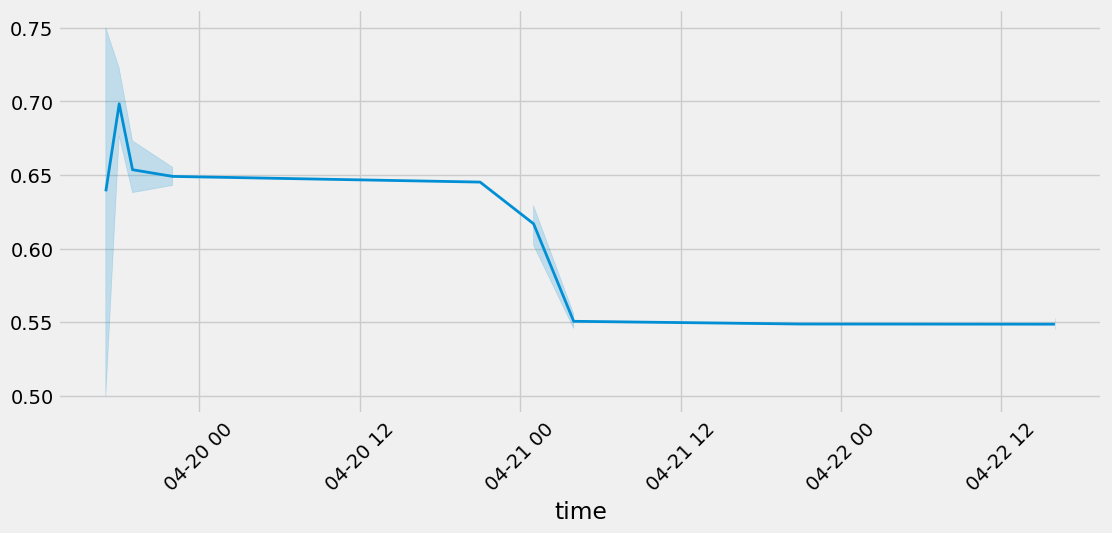

In [36]:
if not CFG.optimize and train_test == 'test':
    figsize = (12, 5)
    plt.figure(figsize=figsize)

    tmp = res[res['pred'] == res['target']]
    tmp['ppv_npv_acc'] = tmp['target'].rolling(len(tmp), min_periods=1).count() / (tmp.index + 1)

    ax = sns.lineplot(x=tmp['time'], y=tmp['ppv_npv_acc'].values)
    ax.lines[0].set_linewidth(2)
    plt.xticks(rotation=45);

# Compare indicator / signal values for bot and optimizer

In [37]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = 'buy'
# ticker = 'METHUSDT'
# month = 1
# day = 25
# hour = 6
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)
# y = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_3.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, '', '', 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, '', '', 0)

# # cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'stoch_slowk', 'stoch_slowd', 'linear_reg', 'linear_reg_angle', 'macd', 'macdsignal', 'macdhist']
# cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'linear_reg', 'linear_reg_angle', 'high_max', 'low_min', 'volume_24']

# higher_features = ['time_4h', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist',  'macd_dir', 
#                    'macdsignal', 'macdsignal_dir']
# y['time_4h'] = y['time'] + pd.to_timedelta(3, unit='h')
# x[['time'] + higher_features] = pd.merge(x[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# x.drop(columns=['time_4h'], inplace=True)
# y.drop(columns=['time_4h'], inplace=True)
# x.ffill(inplace=True)
# x.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
# v = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, '', '', 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, '', '', 0)
# z.tail(48)

# v['time_4h'] = v['time'] + pd.to_timedelta(3, unit='h')
# z[['time'] + higher_features] = pd.merge(z[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# z.drop(columns=['time_4h'], inplace=True)
# v.drop(columns=['time_4h'], inplace=True)
# z.ffill(inplace=True)
# z.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols][-1:])